<a id="tercero"></a>
## 3. *Encoder-Decoder* sobre Texto

Trabajos recientes en redes neuronales han demostrado que se puede aplicar a problemas bastante complejos gracias a la flexibilidad la definición de las redes, además de que se pueden adaptar a distintos tipos de datos brutos (dominios). Con el objetivo de explorar el enfoque anterior de *traducción* de algun tipo de dato, en esta sección deberá realizarlo con texto para traducción de un lenguaje humano a otro (e.g. inglés a alemán, chino a ruso).

<img src="https://www.panoramaila.cz/images/preklady.jpg" width="35%" />


Trabajaremos con el dataset de pares de sentencias bilingues entre distintos idiomas del proyecto __[Tatoeba](http://www.manythings.org/anki/)__. El objetivo entonces consta de tomar un texto en lenguaje natural de algún idioma (*source*) y traducirlo a otro texto en lenguaje natural de otro idioma (*target*), donde cada texto tendrá un largo variable. Lo cual se empleará a través de extrar información del texto *source* (*encoder*) para luego generar el texto *target* (*decoder*) en base a esta información extraída.


Deberá seleccionar el *dataset* que guste para trabajar con la tarea de traducción, comente sobre su decisión. Luego cárgelo con *pandas*.
```python
import pandas as pd
df = pd.read_csv("data/dataset_selected.txt", sep="\t", names=["Source","Target"])
df.head()
```

> a) Visualice los datos ¿Qué es la entrada y qué es la salida? Comente sobre los múltiples significados/sinónimos que puede tener una palabra al ser traducida y cómo propondría arreglar eso. *se espera que pueda implementarlo*

> b) Realice un pre-procesamiento a los textos como se acostumbra para eliminar símbolos inecesarios u otras cosas que estime conveniente, comente sobre la importancia de éste paso. Además de ésto deberá agregar un símbolo al final de la sentencia *target* para indicar un "alto" cuando la red neuronal necesite aprender a generar una sentencia.
```python
import string
table = str.maketrans('', '', string.punctuation) 
def clean_text(text, where=None):
    """ OJO: Sin eliminar el significado de las palabras."""
    text = text.lower()
    tokenize_text = text.split()
    tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
    tokenize_text = [word for word in tokenize_text if word.isalpha()] #remove numbers
    if where =="target":
        tokenize_text = tokenize_text + ["#end"] 
    return tokenize_text
texts_input = list(df['Source'].apply(clean_text))
texts_output = list(df['Target'].apply(clean_text, where='target'))
```

> Cree un conjunto de validación y de pruebas fijos de $N_{exp} = 10000$ datos ¿Cuántos datos quedan para entrenar? 
```python
from sklearn.model_selection import train_test_split
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output,
                                                            test_size=N_exp, random_state=22)
X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=N_exp, random_state=22)
```
*Recuerde que si no puede procesar los datos de entrenamiento adecuadamente siempre puede muestrear en base a la capacidad de cómputo que posea*

> c) Genere un vocabulario, **desde el conjunto de entrenamiento**, sobre las palabras a recibir y generar en la traducción, esto es codificarlas a un valor entero que servirá para que la red las vea en una representación útil a procesar, *comience desde el 1 debido a que el cero será utilizado más adelante*. Para reducir el vocabulario considere las palabras que aparecen un mínimo de *min_count* veces en todo los datos, se aconseja un valor de 3. Comente sobre la importancia de ésto al reducir el vocabulario ¿De qué tamaño es el vocabulario de entrada y salida? ¿La diferencia de ésto podría ser un factor importante?
```python
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]
vocab_source = create_vocab(X_train_l, min_count=3)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=3)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)}  #Converting text to numbers
idx2word_t = ... #Converting number to text
n_words_t = ...
```
Ahora codifique las palabras a los números indexados con el vocabulario. Recuerde que si una palabra en los otros conjuntos, o en el mismo de entrenamiento, no aparece en el vocabulario no se podrá generar una codificación, por lo que será **ignorada** ¿Cómo se podría evitar ésto?
```python
""" Source/input data """
dataX_train = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_train_l]
dataX_valid = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_val_l]
... #do test
""" Target/output data """
dataY_train = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_train_l]
dataY_valid = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_val_l] 
...#do test
```

> d) Debido al largo variable de los textos de entrada y salida será necesario estandarizar ésto para poder trabajar de manera más cómoda en Keras, *cada texto (entrada y salida) pueden tener distinto largo máximo*. Comente sobre la decisión del tipo de *padding*, *pre o post* ¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)?
```python
from keras.preprocessing import sequence
""" INPUT DATA (Origin language) """
max_inp_length = max(map(len,dataX_train))
print("Largo max inp: ",max_inp_length)
word2idx_s["*"] = 0 #padding symbol
idx2word_s[0] = "*"
n_words_s += 1  
X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
...# do valid and test..
""" OUTPUT DATA (Destination language) """
max_out_length = max(map(len,dataY_train)) 
print("Largo max out: ",max_out_length)
word2idx_t["*"] = 0 #padding symbol
idx2word_t[0] = "*"
n_words_t += 1  
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
...#do valid and test..
```

> e) Para evitar que la red obtenga una ganancia por imitar/predecir el símbolo de *padding* que está bastante presente en los datos coloque un peso sobre éste clase, con valor 0, así se evita que tenga impacto en la función objetivo. Ya que *keras* no soporta directamente ésto en series de tiempo coloque el peso a cada instante de tiempo de cada dato de entrenamiento dependiendo de su clase. Comente sobre alguna otra forma en que se podría manejar el evitar que la red prediga en mayoría el símbolo de *padding*.
```python
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]
```

> f) Para lograr la tarea defina una red recurrente del tipo *encoder*-*decoder* como la que se presenta en la siguiente imágen.
<img src="https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png" width="60%" />
En primer lugar defina el *Encoder* que procesara el texto de entrada y retornará un solo vector final, haciendo uso de las capas ya conocidas de *Embedding* para generar un vector denso de palabra y *GRU*, pero en su versión acelerada para GPU.
```python
from keras.models import Sequential
from keras.layers import Embedding,CuDNNGRU
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(CuDNNGRU(128, return_sequences=False))
```
Luego defina la sección que conecta el largo (*timesteps*) de entrada *vs* el de salida.
```python
from keras.layers import RepeatVector
model.add(RepeatVector(max_out_length)) #conection
```
Finalmente defina el *Decoder* para generar la secuencia de salida en texto de palabras en otro idioma, a través de la función *softmax* sobre cada instante de tiempo (*timestep*. 
```python
from keras.layers import CuDNNGRU, TimeDistributed,Dense
model.add(CuDNNGRU(128, return_sequences=True))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()
```
Entrene la red entre 1 a 5 *epochs*, agregando los pesos definidos sobre cada ejemplo de entrenamiento. Además de utilizar una función de pérdida que evita generar explícitamente los *one hot vector*
```python
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
model.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_valid, Y_valid),
         sample_weight = sample_weight) 
```

> g) Debido a lo costoso de tener una red completamente recurrente para entrenar y poder experimentar, cambie el modelo que procesa el *Encoder* por una red convolucional, reduciendo el número de capas pero aumentando las neuronas. Utilice tamaños de *kernel*  igual a 5 y funciones de activaciones relu. Se agregan capas de *BatchNormalization* debido a que en el *Decoder* contamos con redes recurrentes que tienen capa activación distinta a la usada por las convoluciones. La capa de *GlobalMaxPooling1d* es lo que permite reducir toda la información extraída a un único vector, como se realizó anteriormente con *return_sequences=False*, comente sobre la ganancia o desventaja de ésto *vs* la red neuronal.
```python
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization()) #for stability
model.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model.add(RepeatVector(max_out_length)) #conection
model.add(CuDNNGRU(256, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary() 
```
Entrene el modelo igual a lo presentado anteriormente pero ahora por 20 *epochs* ¿Cambian los tiempos de procesamiento y la cantidad de parámetros?

> h) Visualice lo aprendido por el modelo sobre algunos datos del conjunto de entrenamiento y validación, comente lo observado.
```python
def predict_words(y_indexs, data="target"):
    """ Predict until '-#end-' is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["#end"]:
                    return return_val                
    return return_val
n_s = 100
idx = np.random.choice(np.arange(Y_set.shape[0]), size=n_s, replace=False)
Y_set_pred = model.predict_classes(X_set[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_set[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_set[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled))
```

> i) Realice algún cambio esperando que mejore el modelo entrenado, luego vuelva a visualizar lo predicho por la red *vs* lo real. *Debido a lo costoso en entrenar puede optar por realizar solo un cambio pero que sea significativo*.  Se comentan algunas opciones para utilizar y combinar:
* Cambiar  el *embedding* por alguno pre-entrenado
* Agregar regularizadores
* Asignar peso a las clases/palabras de salida
* Cambiar *Global max pooling* por *Average max pooling*
* Aumentar o reducir capas
* Aumentar o reducir neuronas/unidades  

> j) A pesar de que la tarea de medir qué tan similar es un texto a otro ya es un área de investigación propia [[6]](#refs), usted deberá utilizar alguna métrica de desempeño para ver qué tan buena es la traducción del texto *versus* el texto real entregado. Debido a que la métrica de *Exact Matching* (EM) puede ser muy drástica, mida *f1 score* por texto además de proponer alguna otra técnica de evaluación para medir sobre el conjunto de pruebas y los otros conjuntos si estima conveniente. Puede basarse en otros trabajos como *Image captioning* o *Text summary*. 
*Hint: Debido a los problemas de memoria al realizar un forward-pass, solo seleccione un subconjunto $N_{sub}$ del conjunto de pruebas para realizar ésta evaluación, se aconseja entre 1000 y 5000.*
```python
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
m = MultiLabelBinarizer().fit([np.arange(n_words_t)]) 
def calculate_f1(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])[0] #onehot of words appear
    binarized_pred = m.transform([predict_words(pred)])[0] #onehot of words appear
    return f1_score(binarized_true, binarized_pred, average='binary') #only on appearing words
f1_final = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_true,Y_hat)])
f1_final*100 #porcentaje
```
>> La función de *f1 score* en este extracto se calcula en base al *precision* y *recall* de que aparezca cada una de las palabras predichas dentro de las palabras reales (como si cada palabra fuera una clase de "aparece" o no), **sin importar el orden ni la ocurrencia**.


> k) En ves de volver a variar el modelo de *Encoder*, dejaremos una representación manual explícita (*no entrenable*) a través de extraer características manuales de los textos *source*, como por ejemplo representaciones *term frequency* (TF) o TF-IDF, proporcionadas a través de __[sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)__. Luego, con esto generado, defina y entrene el modelo *Decoder* neuronal como el presentado en las preguntas anteriores, ésto es comenzar desde la capa *RepeatVector* hasta llegar a la clasificación sobre el texto *target*. Compare el desempeño con lo presentado en (j) y lo visualizado en (h).
```python
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy_fun(doc):
    return doc
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,
                         token_pattern=None,use_idf= True, smooth_idf=True, norm='l2')   
X_train_tfidf = tf_idf.fit_transform(dataX_train).astype('float32').todense()
...#do over valid and test..
```

In [53]:
import pandas as pd
import string
import numpy as np
import spacy
import progressbar
import matplotlib.pyplot as plt
from spacy.lang.ru import Russian
from keras.models import Sequential
from keras.layers import CuDNNGRU, TimeDistributed, Dense, Embedding, RepeatVector
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization
import keras.backend as K

K.set_image_dim_ordering('tf')

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [2]:
df = pd.read_csv("ru/rus.txt", sep="\t", names=["Source","Target"])
df.head()
df.drop_duplicates(subset=['Source', 'Target'], keep='first', inplace=True)

In [3]:
df.describe()

,Source,Target
count,359068,359068
unique,248698,322868
top,You seem very nervous this morning.,"Том сказал, что не планирует этого делать."
freq,23,12


In [4]:
df.shape

(359068, 2)

Se observa, que la data, de partida es muy grande, por lo que probablemente por razones de memoria se deba reducir. Igualemente y volviendo a la data, se encuentra que existen muchos simbolos en las oraciones, tales como exclamación y puntuación, además de que existen palabras del inglés que están abreviadas. Igualmente, se ve que se reduce mucho la cuenta única de datos originales a únicos, esto debido a que exite mas de una forma de decir una oración tanto de inglés a ruso como de ruso a inglés. Esto debido a la existencia de sinónimos, tal como se menciona en el enunciado. Es por esta razón, y considerando que los sinónimos se prefieren entre sí dado el contexto, que además se le aplica un pre procesamiento de lemmatización a las palabras que conforman el dataset, de esta forma lo que se considera único no es la palabra en si, sino la tupla (palabra, lemma), de forma que la serie haría la transición no sólo hacia la palabra, sino hacia el lemma de esta igualemnte.

In [5]:
nlp_en = spacy.load('en_core_web_sm')
nlp_ru = Russian()

def clean_and_lemma(dfText):
    bar = progressbar.ProgressBar(maxval=dfText.shape[0], \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    ret_x = []
    ret_y = []
    bar.start()
    for i in range(dfText.shape[0]):
        local_x = []
        local_y = []
        doc = nlp_ru(dfText['Target'][i])
        doc2 = nlp_en(dfText['Source'][i])
        for token in doc2:
            if(token.is_alpha or ('x' in token.shape_.lower())):
                local_x.append((token.text, token.lemma_))
        local_x.append(("<end>", "<end>"))
        for token in doc:
            if(token.is_alpha or ('x' in token.shape_.lower())):
                local_y.append((token.text, token.lemma_))
        local_y.append(("<end>", "<end>"))
        local_x = np.asarray(local_x)
        local_y = np.asarray(local_y)
        ret_x.append(local_x)
        ret_y.append(local_y)
        bar.update(i+1)
    ret_x = np.asarray(ret_x)
    ret_y = np.asarray(ret_y)
    bar.finish()
    return ret_x, ret_y

In [6]:
texts_input, texts_output = clean_and_lemma(df)
print(texts_input[1270])

[========================================================================] 100%


[['I' '-PRON-']
 ["'m" 'be']
 ['lying' 'lie']
 ['<end>' '<end>']]


In [92]:
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output,
                                                            test_size=10000, random_state=22)
X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=10000, random_state=22)
X_train_l, X_residual_l, Y_train_l, Y_residual_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=int(X_train_l.shape[0]/2), random_state=22)

Dado a que aún con la reducción de datos de testeo y de validación aún quedan mas de 300.000 datos, debemos reducirlos a la mitad de forma aleatoria para así lograr mantener el desbalance de clase y un afectar lo menos posible al vocabulario resultante, mientras que aún se puede entrenar.

In [102]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    vocab_lemma = []
    for sentence in texts:
        for word, lemma in sentence:
            if word not in count_vocab:
                count_vocab[word] = {lemma: 1}
            else:
                if lemma not in count_vocab[word]:
                    count_vocab[word][lemma] = 1
                else:
                    count_vocab[word][lemma] += 1
                    if (count_vocab[word][lemma] == min_count):
                        vocab_lemma.append(word + "/" + lemma)
    return np.asarray(vocab_lemma)
vocab_source = create_vocab(X_train_l, min_count=5)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=5)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)}  #Converting text to numbers
idx2word_t = {i+1: w for i, w in enumerate(vocab_target)} #Converting number to text
n_words_t = len(vocab_target)

In [103]:
print(f"Source vocabulary length: {n_words_s}\nTarget vocabulary length: {n_words_t}\n")

Source vocabulary length: 5481
Target vocabulary length: 10793



Dado al tamaño del set de datos que se maneja, y considerando la naturaleza del idioma ruso, se tiene un vocabulario sumamente grande para la salida, además de que existen demasiadas formas de decir una cosa del inglés al ruso, tal como se observó anteriormente. Es por esto que se debe reducir el vocabulario usando un min count de 5, ya que con cualquier otro valor menor es demasiada data y no se puede entrenar la red recurrente. La forma encontrada y trivial de lidiar con esto y obtener buenos resultados es contando con mas recursos para lidiar con un vocabulario mas grande.

In [104]:
""" Source/input data """
dataX_train = [[word2idx_s[word + "/" + lemma] for word, lemma in sent if word + "/" + lemma in word2idx_s] for sent in X_train_l]
dataX_valid = [[word2idx_s[word + "/" + lemma] for word, lemma in sent if word + "/" + lemma in word2idx_s] for sent in X_val_l]
dataX_test = [[word2idx_s[word + "/" + lemma] for word, lemma in sent if word + "/" + lemma in word2idx_s] for sent in X_test_l]
""" Target/output data """
dataY_train = [[word2idx_t[word + "/" + lemma] for word, lemma in sent if word + "/" + lemma in word2idx_t] for sent in Y_train_l]
dataY_valid = [[word2idx_t[word + "/" + lemma] for word, lemma in sent if word + "/" + lemma in word2idx_t] for sent in Y_val_l] 
dataY_test = [[word2idx_t[word + "/" + lemma] for word, lemma in sent if word + "/" + lemma in word2idx_t] for sent in Y_test_l]

In [105]:
""" INPUT DATA (Origin language) """
max_inp_length1 = max(map(len,dataX_train))
max_inp_length2 = max(map(len,dataX_valid))
max_inp_length3 = max(map(len,dataX_train))
max_inp_length = max(max_inp_length1, max(max_inp_length2, max_inp_length3))
print("Largo max inp: ",max_inp_length)
word2idx_s["*"] = 0 #padding symbol
idx2word_s[0] = "*"
n_words_s += 1  
X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
X_valid = sequence.pad_sequences(dataX_valid, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
""" OUTPUT DATA (Destination language) """
max_out_length1 = max(map(len,dataY_train))
max_out_length2 = max(map(len,dataY_valid))
max_out_length3 = max(map(len,dataY_train))
max_out_length = max(max_out_length1, max(max_out_length2, max_out_length3))
print("Largo max out: ",max_out_length)
word2idx_t["*"] = 0 #padding symbol
idx2word_t[0] = "*"
n_words_t += 1  
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
Y_valid = sequence.pad_sequences(dataY_valid, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["*"])

Largo max inp:  44
Largo max out:  40


In [106]:
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]

In [107]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(CuDNNGRU(128, return_sequences=False))

model.add(RepeatVector(max_out_length))

model.add(CuDNNGRU(128, return_sequences=True))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 44, 100)           548200    
_________________________________________________________________
cu_dnngru_35 (CuDNNGRU)      (None, 44, 64)            31872     
_________________________________________________________________
cu_dnngru_36 (CuDNNGRU)      (None, 128)               74496     
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 40, 128)           0         
_________________________________________________________________
cu_dnngru_37 (CuDNNGRU)      (None, 40, 128)           99072     
_________________________________________________________________
cu_dnngru_38 (CuDNNGRU)      (None, 40, 64)            37248     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 40, 10794)         701610    
Total para

In [108]:
print(Y_train.shape)

(169534, 40)


In [109]:
Y_train = Y_train.reshape(Y_train.shape[0],Y_train.shape[1],1)
Y_valid = Y_valid.reshape(Y_valid.shape[0],Y_valid.shape[1],1)
Y_test = Y_test.reshape(Y_test.shape[0],Y_test.shape[1],1)

In [110]:
hist1 = model.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_valid, Y_valid),
         sample_weight = sample_weight) 

Train on 169534 samples, validate on 10000 samples
Epoch 1/3


 79872/169534 [=============>................] - ETA: 16:33 - loss: 9.28 - ETA: 9:09 - loss: 9.2860 - ETA: 6:41 - loss: 9.285 - ETA: 5:27 - loss: 9.284 - ETA: 4:43 - loss: 9.282 - ETA: 4:13 - loss: 9.281 - ETA: 3:51 - loss: 9.278 - ETA: 3:35 - loss: 9.276 - ETA: 3:23 - loss: 9.271 - ETA: 3:13 - loss: 9.265 - ETA: 3:05 - loss: 9.257 - ETA: 2:58 - loss: 9.245 - ETA: 2:52 - loss: 9.228 - ETA: 2:47 - loss: 9.204 - ETA: 2:42 - loss: 9.174 - ETA: 2:39 - loss: 9.140 - ETA: 2:35 - loss: 9.104 - ETA: 2:32 - loss: 9.065 - ETA: 2:29 - loss: 9.027 - ETA: 2:27 - loss: 8.986 - ETA: 2:24 - loss: 8.946 - ETA: 2:22 - loss: 8.906 - ETA: 2:20 - loss: 8.867 - ETA: 2:19 - loss: 8.826 - ETA: 2:17 - loss: 8.787 - ETA: 2:15 - loss: 8.746 - ETA: 2:14 - loss: 8.706 - ETA: 2:12 - loss: 8.666 - ETA: 2:11 - loss: 8.627 - ETA: 2:10 - loss: 8.588 - ETA: 2:09 - loss: 8.549 - ETA: 2:08 - loss: 8.512 - ETA: 2:07 - loss: 8.474 - ETA: 2:06 - loss: 8.437 - ETA: 2:05 - loss: 8.400 - ETA: 2:04 - loss: 8.365 - ETA: 2:03 - lo

169534/169534 [==============================] - ETA: 1s - loss: 6.190 - ETA: 1s - loss: 6.190 - ETA: 1s - loss: 6.189 - ETA: 1s - loss: 6.189 - ETA: 0s - loss: 6.189 - ETA: 0s - loss: 6.188 - ETA: 0s - loss: 6.188 - ETA: 0s - loss: 6.187 - ETA: 0s - loss: 6.187 - ETA: 0s - loss: 6.187 - 111s 655us/step - loss: 6.1870 - val_loss: 13.7027
Epoch 2/3


 80896/169534 [=============>................] - ETA: 1:53 - loss: 5.937 - ETA: 1:49 - loss: 5.944 - ETA: 1:48 - loss: 5.918 - ETA: 1:47 - loss: 5.935 - ETA: 1:47 - loss: 5.941 - ETA: 1:46 - loss: 5.956 - ETA: 1:46 - loss: 5.966 - ETA: 1:46 - loss: 5.962 - ETA: 1:45 - loss: 5.966 - ETA: 1:45 - loss: 5.963 - ETA: 1:45 - loss: 5.968 - ETA: 1:45 - loss: 5.971 - ETA: 1:45 - loss: 5.969 - ETA: 1:44 - loss: 5.971 - ETA: 1:44 - loss: 5.972 - ETA: 1:44 - loss: 5.968 - ETA: 1:44 - loss: 5.963 - ETA: 1:44 - loss: 5.963 - ETA: 1:44 - loss: 5.964 - ETA: 1:43 - loss: 5.961 - ETA: 1:43 - loss: 5.962 - ETA: 1:43 - loss: 5.960 - ETA: 1:43 - loss: 5.956 - ETA: 1:43 - loss: 5.953 - ETA: 1:42 - loss: 5.953 - ETA: 1:42 - loss: 5.953 - ETA: 1:42 - loss: 5.955 - ETA: 1:42 - loss: 5.953 - ETA: 1:42 - loss: 5.955 - ETA: 1:42 - loss: 5.951 - ETA: 1:41 - loss: 5.952 - ETA: 1:41 - loss: 5.951 - ETA: 1:41 - loss: 5.951 - ETA: 1:41 - loss: 5.947 - ETA: 1:41 - loss: 5.945 - ETA: 1:41 - loss: 5.947 - ETA: 1:40 - los

169534/169534 [==============================] - ETA: 0s - loss: 5.872 - ETA: 0s - loss: 5.872 - ETA: 0s - loss: 5.872 - ETA: 0s - loss: 5.872 - ETA: 0s - loss: 5.872 - ETA: 0s - loss: 5.872 - 110s 646us/step - loss: 5.8723 - val_loss: 14.4917
Epoch 3/3


 80896/169534 [=============>................] - ETA: 1:53 - loss: 5.771 - ETA: 1:49 - loss: 5.817 - ETA: 1:48 - loss: 5.793 - ETA: 1:47 - loss: 5.786 - ETA: 1:47 - loss: 5.796 - ETA: 1:46 - loss: 5.817 - ETA: 1:46 - loss: 5.817 - ETA: 1:46 - loss: 5.819 - ETA: 1:46 - loss: 5.815 - ETA: 1:45 - loss: 5.803 - ETA: 1:45 - loss: 5.804 - ETA: 1:45 - loss: 5.795 - ETA: 1:45 - loss: 5.791 - ETA: 1:45 - loss: 5.798 - ETA: 1:44 - loss: 5.796 - ETA: 1:44 - loss: 5.799 - ETA: 1:44 - loss: 5.800 - ETA: 1:44 - loss: 5.797 - ETA: 1:44 - loss: 5.796 - ETA: 1:43 - loss: 5.797 - ETA: 1:43 - loss: 5.802 - ETA: 1:43 - loss: 5.801 - ETA: 1:43 - loss: 5.800 - ETA: 1:43 - loss: 5.799 - ETA: 1:43 - loss: 5.798 - ETA: 1:42 - loss: 5.799 - ETA: 1:42 - loss: 5.796 - ETA: 1:42 - loss: 5.796 - ETA: 1:42 - loss: 5.792 - ETA: 1:42 - loss: 5.796 - ETA: 1:41 - loss: 5.797 - ETA: 1:41 - loss: 5.797 - ETA: 1:41 - loss: 5.798 - ETA: 1:41 - loss: 5.795 - ETA: 1:41 - loss: 5.793 - ETA: 1:41 - loss: 5.792 - ETA: 1:40 - los

169534/169534 [==============================] - ETA: 0s - loss: 5.751 - ETA: 0s - loss: 5.751 - ETA: 0s - loss: 5.751 - ETA: 0s - loss: 5.751 - ETA: 0s - loss: 5.751 - ETA: 0s - loss: 5.751 - 109s 646us/step - loss: 5.7513 - val_loss: 14.5741


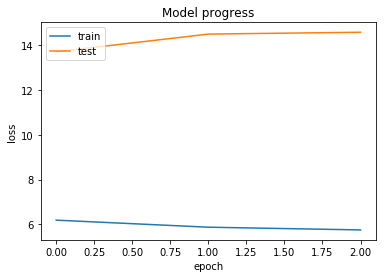

In [112]:
plt.figure(1)
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [113]:
modelCnn = Sequential()
modelCnn.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
modelCnn.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modelCnn.add(BatchNormalization()) #for stability
modelCnn.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modelCnn.add(BatchNormalization())
modelCnn.add(GlobalMaxPooling1D()) #aka to return_sequences=False
modelCnn.add(RepeatVector(max_out_length)) #conection
modelCnn.add(CuDNNGRU(256, return_sequences=True))
modelCnn.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
modelCnn.summary() 
modelCnn.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 44, 100)           548200    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 44, 256)           128256    
_________________________________________________________________
batch_normalization_7 (Batch (None, 44, 256)           1024      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 44, 256)           327936    
_________________________________________________________________
batch_normalization_8 (Batch (None, 44, 256)           1024      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 40, 256)           0         
__________

In [114]:
hist2 = modelCnn.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_valid, Y_valid),
         sample_weight = sample_weight)

Train on 169534 samples, validate on 10000 samples
Epoch 1/20


 79616/169534 [=============>................] - ETA: 19:30 - loss: 9.31 - ETA: 10:47 - loss: 9.19 - ETA: 7:52 - loss: 9.0811 - ETA: 6:24 - loss: 8.967 - ETA: 5:31 - loss: 8.855 - ETA: 4:56 - loss: 8.743 - ETA: 4:31 - loss: 8.628 - ETA: 4:12 - loss: 8.518 - ETA: 3:58 - loss: 8.402 - ETA: 3:46 - loss: 8.293 - ETA: 3:36 - loss: 8.175 - ETA: 3:28 - loss: 8.062 - ETA: 3:21 - loss: 7.956 - ETA: 3:15 - loss: 7.862 - ETA: 3:10 - loss: 7.776 - ETA: 3:05 - loss: 7.701 - ETA: 3:01 - loss: 7.626 - ETA: 2:58 - loss: 7.563 - ETA: 2:55 - loss: 7.505 - ETA: 2:52 - loss: 7.449 - ETA: 2:49 - loss: 7.395 - ETA: 2:46 - loss: 7.344 - ETA: 2:44 - loss: 7.296 - ETA: 2:42 - loss: 7.253 - ETA: 2:40 - loss: 7.216 - ETA: 2:38 - loss: 7.177 - ETA: 2:37 - loss: 7.145 - ETA: 2:35 - loss: 7.112 - ETA: 2:34 - loss: 7.084 - ETA: 2:32 - loss: 7.056 - ETA: 2:31 - loss: 7.032 - ETA: 2:30 - loss: 7.006 - ETA: 2:29 - loss: 6.983 - ETA: 2:27 - loss: 6.963 - ETA: 2:26 - loss: 6.941 - ETA: 2:25 - loss: 6.918 - ETA: 2:24 - lo

169534/169534 [==============================] - ETA: 2s - loss: 5.339 - ETA: 2s - loss: 5.338 - ETA: 2s - loss: 5.338 - ETA: 2s - loss: 5.337 - ETA: 2s - loss: 5.336 - ETA: 1s - loss: 5.335 - ETA: 1s - loss: 5.334 - ETA: 1s - loss: 5.333 - ETA: 1s - loss: 5.332 - ETA: 1s - loss: 5.331 - ETA: 0s - loss: 5.330 - ETA: 0s - loss: 5.329 - ETA: 0s - loss: 5.328 - ETA: 0s - loss: 5.328 - ETA: 0s - loss: 5.327 - 133s 783us/step - loss: 5.3271 - val_loss: 11.1022
Epoch 2/20


 80384/169534 [=============>................] - ETA: 2:08 - loss: 4.679 - ETA: 2:06 - loss: 4.765 - ETA: 2:08 - loss: 4.778 - ETA: 2:12 - loss: 4.775 - ETA: 2:10 - loss: 4.761 - ETA: 2:09 - loss: 4.749 - ETA: 2:08 - loss: 4.741 - ETA: 2:07 - loss: 4.731 - ETA: 2:07 - loss: 4.742 - ETA: 2:06 - loss: 4.747 - ETA: 2:05 - loss: 4.743 - ETA: 2:05 - loss: 4.744 - ETA: 2:04 - loss: 4.733 - ETA: 2:04 - loss: 4.731 - ETA: 2:04 - loss: 4.724 - ETA: 2:03 - loss: 4.724 - ETA: 2:03 - loss: 4.714 - ETA: 2:03 - loss: 4.713 - ETA: 2:02 - loss: 4.717 - ETA: 2:02 - loss: 4.713 - ETA: 2:02 - loss: 4.711 - ETA: 2:01 - loss: 4.710 - ETA: 2:01 - loss: 4.702 - ETA: 2:01 - loss: 4.706 - ETA: 2:01 - loss: 4.707 - ETA: 2:00 - loss: 4.709 - ETA: 2:00 - loss: 4.712 - ETA: 2:00 - loss: 4.707 - ETA: 2:00 - loss: 4.711 - ETA: 2:00 - loss: 4.713 - ETA: 1:59 - loss: 4.714 - ETA: 1:59 - loss: 4.710 - ETA: 1:59 - loss: 4.705 - ETA: 1:59 - loss: 4.705 - ETA: 1:59 - loss: 4.704 - ETA: 1:58 - loss: 4.708 - ETA: 1:58 - los

169534/169534 [==============================] - ETA: 1s - loss: 4.426 - ETA: 1s - loss: 4.425 - ETA: 1s - loss: 4.425 - ETA: 1s - loss: 4.425 - ETA: 1s - loss: 4.424 - ETA: 1s - loss: 4.424 - ETA: 0s - loss: 4.423 - ETA: 0s - loss: 4.423 - ETA: 0s - loss: 4.422 - ETA: 0s - loss: 4.422 - ETA: 0s - loss: 4.421 - 131s 770us/step - loss: 4.4217 - val_loss: 11.8419
Epoch 3/20


 80384/169534 [=============>................] - ETA: 2:23 - loss: 4.072 - ETA: 2:13 - loss: 4.119 - ETA: 2:09 - loss: 4.080 - ETA: 2:07 - loss: 4.142 - ETA: 2:07 - loss: 4.140 - ETA: 2:09 - loss: 4.125 - ETA: 2:08 - loss: 4.121 - ETA: 2:10 - loss: 4.122 - ETA: 2:09 - loss: 4.124 - ETA: 2:10 - loss: 4.135 - ETA: 2:10 - loss: 4.135 - ETA: 2:10 - loss: 4.129 - ETA: 2:10 - loss: 4.119 - ETA: 2:09 - loss: 4.110 - ETA: 2:10 - loss: 4.111 - ETA: 2:09 - loss: 4.114 - ETA: 2:09 - loss: 4.109 - ETA: 2:09 - loss: 4.108 - ETA: 2:09 - loss: 4.112 - ETA: 2:09 - loss: 4.113 - ETA: 2:09 - loss: 4.112 - ETA: 2:08 - loss: 4.115 - ETA: 2:08 - loss: 4.118 - ETA: 2:08 - loss: 4.122 - ETA: 2:07 - loss: 4.121 - ETA: 2:07 - loss: 4.118 - ETA: 2:07 - loss: 4.121 - ETA: 2:07 - loss: 4.121 - ETA: 2:06 - loss: 4.114 - ETA: 2:06 - loss: 4.116 - ETA: 2:06 - loss: 4.114 - ETA: 2:06 - loss: 4.119 - ETA: 2:05 - loss: 4.118 - ETA: 2:05 - loss: 4.114 - ETA: 2:04 - loss: 4.113 - ETA: 2:04 - loss: 4.110 - ETA: 2:04 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.957 - ETA: 1s - loss: 3.957 - ETA: 1s - loss: 3.957 - ETA: 1s - loss: 3.956 - ETA: 1s - loss: 3.956 - ETA: 0s - loss: 3.955 - ETA: 0s - loss: 3.955 - ETA: 0s - loss: 3.955 - ETA: 0s - loss: 3.955 - ETA: 0s - loss: 3.955 - ETA: 0s - loss: 3.954 - 129s 760us/step - loss: 3.9548 - val_loss: 12.0093
Epoch 4/20


 80384/169534 [=============>................] - ETA: 2:05 - loss: 3.787 - ETA: 2:05 - loss: 3.744 - ETA: 2:04 - loss: 3.774 - ETA: 2:04 - loss: 3.728 - ETA: 2:04 - loss: 3.729 - ETA: 2:04 - loss: 3.739 - ETA: 2:04 - loss: 3.751 - ETA: 2:03 - loss: 3.743 - ETA: 2:03 - loss: 3.732 - ETA: 2:03 - loss: 3.735 - ETA: 2:03 - loss: 3.751 - ETA: 2:03 - loss: 3.744 - ETA: 2:02 - loss: 3.742 - ETA: 2:02 - loss: 3.739 - ETA: 2:02 - loss: 3.728 - ETA: 2:02 - loss: 3.718 - ETA: 2:02 - loss: 3.713 - ETA: 2:02 - loss: 3.725 - ETA: 2:01 - loss: 3.739 - ETA: 2:01 - loss: 3.748 - ETA: 2:01 - loss: 3.742 - ETA: 2:01 - loss: 3.744 - ETA: 2:01 - loss: 3.740 - ETA: 2:01 - loss: 3.736 - ETA: 2:00 - loss: 3.732 - ETA: 2:00 - loss: 3.733 - ETA: 2:00 - loss: 3.734 - ETA: 2:00 - loss: 3.729 - ETA: 2:00 - loss: 3.729 - ETA: 2:00 - loss: 3.727 - ETA: 1:59 - loss: 3.735 - ETA: 1:59 - loss: 3.740 - ETA: 1:59 - loss: 3.740 - ETA: 1:59 - loss: 3.741 - ETA: 1:59 - loss: 3.742 - ETA: 1:58 - loss: 3.739 - ETA: 1:58 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.643 - ETA: 1s - loss: 3.643 - ETA: 1s - loss: 3.642 - ETA: 1s - loss: 3.642 - ETA: 1s - loss: 3.642 - ETA: 1s - loss: 3.642 - ETA: 0s - loss: 3.642 - ETA: 0s - loss: 3.642 - ETA: 0s - loss: 3.642 - ETA: 0s - loss: 3.642 - ETA: 0s - loss: 3.642 - 129s 761us/step - loss: 3.6425 - val_loss: 12.2328
Epoch 5/20


 80384/169534 [=============>................] - ETA: 2:05 - loss: 3.443 - ETA: 2:05 - loss: 3.411 - ETA: 2:04 - loss: 3.429 - ETA: 2:03 - loss: 3.437 - ETA: 2:03 - loss: 3.422 - ETA: 2:04 - loss: 3.419 - ETA: 2:08 - loss: 3.396 - ETA: 2:07 - loss: 3.419 - ETA: 2:06 - loss: 3.432 - ETA: 2:06 - loss: 3.425 - ETA: 2:06 - loss: 3.421 - ETA: 2:06 - loss: 3.424 - ETA: 2:07 - loss: 3.431 - ETA: 2:07 - loss: 3.441 - ETA: 2:07 - loss: 3.445 - ETA: 2:07 - loss: 3.451 - ETA: 2:07 - loss: 3.460 - ETA: 2:06 - loss: 3.467 - ETA: 2:06 - loss: 3.468 - ETA: 2:05 - loss: 3.466 - ETA: 2:05 - loss: 3.470 - ETA: 2:05 - loss: 3.465 - ETA: 2:04 - loss: 3.462 - ETA: 2:04 - loss: 3.470 - ETA: 2:04 - loss: 3.468 - ETA: 2:03 - loss: 3.473 - ETA: 2:03 - loss: 3.469 - ETA: 2:03 - loss: 3.462 - ETA: 2:03 - loss: 3.457 - ETA: 2:03 - loss: 3.459 - ETA: 2:03 - loss: 3.461 - ETA: 2:03 - loss: 3.459 - ETA: 2:03 - loss: 3.463 - ETA: 2:03 - loss: 3.463 - ETA: 2:03 - loss: 3.464 - ETA: 2:03 - loss: 3.465 - ETA: 2:02 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.413 - ETA: 1s - loss: 3.412 - ETA: 1s - loss: 3.412 - ETA: 1s - loss: 3.412 - ETA: 1s - loss: 3.412 - ETA: 1s - loss: 3.412 - ETA: 0s - loss: 3.412 - ETA: 0s - loss: 3.412 - ETA: 0s - loss: 3.412 - ETA: 0s - loss: 3.411 - ETA: 0s - loss: 3.411 - 129s 763us/step - loss: 3.4118 - val_loss: 12.4087
Epoch 6/20


 80384/169534 [=============>................] - ETA: 2:04 - loss: 3.257 - ETA: 2:04 - loss: 3.302 - ETA: 2:04 - loss: 3.282 - ETA: 2:04 - loss: 3.282 - ETA: 2:04 - loss: 3.275 - ETA: 2:04 - loss: 3.279 - ETA: 2:04 - loss: 3.291 - ETA: 2:04 - loss: 3.283 - ETA: 2:04 - loss: 3.284 - ETA: 2:04 - loss: 3.283 - ETA: 2:04 - loss: 3.277 - ETA: 2:04 - loss: 3.282 - ETA: 2:03 - loss: 3.277 - ETA: 2:03 - loss: 3.274 - ETA: 2:03 - loss: 3.279 - ETA: 2:03 - loss: 3.282 - ETA: 2:03 - loss: 3.276 - ETA: 2:03 - loss: 3.273 - ETA: 2:03 - loss: 3.271 - ETA: 2:03 - loss: 3.272 - ETA: 2:03 - loss: 3.276 - ETA: 2:02 - loss: 3.266 - ETA: 2:02 - loss: 3.262 - ETA: 2:02 - loss: 3.264 - ETA: 2:02 - loss: 3.271 - ETA: 2:02 - loss: 3.266 - ETA: 2:01 - loss: 3.266 - ETA: 2:01 - loss: 3.262 - ETA: 2:01 - loss: 3.261 - ETA: 2:01 - loss: 3.259 - ETA: 2:01 - loss: 3.267 - ETA: 2:00 - loss: 3.269 - ETA: 2:00 - loss: 3.275 - ETA: 2:00 - loss: 3.272 - ETA: 2:00 - loss: 3.266 - ETA: 2:00 - loss: 3.268 - ETA: 1:59 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.225 - ETA: 1s - loss: 3.225 - ETA: 1s - loss: 3.225 - ETA: 1s - loss: 3.224 - ETA: 1s - loss: 3.224 - ETA: 0s - loss: 3.224 - ETA: 0s - loss: 3.224 - ETA: 0s - loss: 3.224 - ETA: 0s - loss: 3.224 - ETA: 0s - loss: 3.224 - ETA: 0s - loss: 3.224 - 129s 760us/step - loss: 3.2243 - val_loss: 12.3726
Epoch 7/20


 80384/169534 [=============>................] - ETA: 2:12 - loss: 3.192 - ETA: 2:08 - loss: 3.180 - ETA: 2:07 - loss: 3.143 - ETA: 2:07 - loss: 3.159 - ETA: 2:07 - loss: 3.136 - ETA: 2:06 - loss: 3.138 - ETA: 2:06 - loss: 3.126 - ETA: 2:05 - loss: 3.113 - ETA: 2:05 - loss: 3.105 - ETA: 2:04 - loss: 3.107 - ETA: 2:04 - loss: 3.111 - ETA: 2:04 - loss: 3.128 - ETA: 2:04 - loss: 3.136 - ETA: 2:03 - loss: 3.142 - ETA: 2:03 - loss: 3.133 - ETA: 2:03 - loss: 3.131 - ETA: 2:03 - loss: 3.128 - ETA: 2:02 - loss: 3.124 - ETA: 2:02 - loss: 3.123 - ETA: 2:02 - loss: 3.122 - ETA: 2:02 - loss: 3.126 - ETA: 2:01 - loss: 3.120 - ETA: 2:01 - loss: 3.128 - ETA: 2:01 - loss: 3.126 - ETA: 2:01 - loss: 3.120 - ETA: 2:00 - loss: 3.121 - ETA: 2:00 - loss: 3.120 - ETA: 2:00 - loss: 3.123 - ETA: 2:00 - loss: 3.121 - ETA: 2:00 - loss: 3.122 - ETA: 1:59 - loss: 3.117 - ETA: 1:59 - loss: 3.112 - ETA: 1:59 - loss: 3.109 - ETA: 1:59 - loss: 3.102 - ETA: 1:59 - loss: 3.100 - ETA: 1:58 - loss: 3.099 - ETA: 1:58 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.070 - ETA: 1s - loss: 3.070 - ETA: 1s - loss: 3.070 - ETA: 1s - loss: 3.070 - ETA: 1s - loss: 3.070 - ETA: 0s - loss: 3.070 - ETA: 0s - loss: 3.070 - ETA: 0s - loss: 3.070 - ETA: 0s - loss: 3.070 - ETA: 0s - loss: 3.070 - ETA: 0s - loss: 3.070 - 128s 756us/step - loss: 3.0703 - val_loss: 12.3838
Epoch 8/20


 80384/169534 [=============>................] - ETA: 2:10 - loss: 3.049 - ETA: 2:08 - loss: 3.132 - ETA: 2:06 - loss: 3.056 - ETA: 2:05 - loss: 3.014 - ETA: 2:05 - loss: 2.995 - ETA: 2:05 - loss: 3.003 - ETA: 2:04 - loss: 2.996 - ETA: 2:04 - loss: 2.977 - ETA: 2:04 - loss: 2.971 - ETA: 2:03 - loss: 2.973 - ETA: 2:03 - loss: 2.982 - ETA: 2:03 - loss: 2.987 - ETA: 2:03 - loss: 2.984 - ETA: 2:03 - loss: 2.981 - ETA: 2:03 - loss: 2.989 - ETA: 2:02 - loss: 2.981 - ETA: 2:02 - loss: 2.982 - ETA: 2:02 - loss: 2.986 - ETA: 2:02 - loss: 2.979 - ETA: 2:02 - loss: 2.977 - ETA: 2:01 - loss: 2.969 - ETA: 2:01 - loss: 2.981 - ETA: 2:01 - loss: 2.975 - ETA: 2:01 - loss: 2.977 - ETA: 2:00 - loss: 2.974 - ETA: 2:00 - loss: 2.978 - ETA: 2:00 - loss: 2.975 - ETA: 2:00 - loss: 2.969 - ETA: 2:00 - loss: 2.969 - ETA: 1:59 - loss: 2.968 - ETA: 1:59 - loss: 2.976 - ETA: 1:59 - loss: 2.977 - ETA: 1:59 - loss: 2.976 - ETA: 1:59 - loss: 2.972 - ETA: 1:59 - loss: 2.975 - ETA: 1:58 - loss: 2.976 - ETA: 1:58 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.937 - ETA: 1s - loss: 2.936 - ETA: 1s - loss: 2.936 - ETA: 1s - loss: 2.936 - ETA: 1s - loss: 2.936 - ETA: 0s - loss: 2.936 - ETA: 0s - loss: 2.936 - ETA: 0s - loss: 2.936 - ETA: 0s - loss: 2.935 - ETA: 0s - loss: 2.935 - ETA: 0s - loss: 2.935 - 129s 759us/step - loss: 2.9356 - val_loss: 12.8612
Epoch 9/20


 80384/169534 [=============>................] - ETA: 2:04 - loss: 2.695 - ETA: 2:13 - loss: 2.755 - ETA: 2:10 - loss: 2.804 - ETA: 2:08 - loss: 2.843 - ETA: 2:07 - loss: 2.837 - ETA: 2:08 - loss: 2.849 - ETA: 2:09 - loss: 2.855 - ETA: 2:08 - loss: 2.862 - ETA: 2:09 - loss: 2.861 - ETA: 2:09 - loss: 2.878 - ETA: 2:08 - loss: 2.879 - ETA: 2:07 - loss: 2.866 - ETA: 2:07 - loss: 2.884 - ETA: 2:08 - loss: 2.871 - ETA: 2:08 - loss: 2.867 - ETA: 2:07 - loss: 2.852 - ETA: 2:06 - loss: 2.852 - ETA: 2:07 - loss: 2.851 - ETA: 2:07 - loss: 2.839 - ETA: 2:07 - loss: 2.836 - ETA: 2:06 - loss: 2.830 - ETA: 2:07 - loss: 2.833 - ETA: 2:07 - loss: 2.835 - ETA: 2:06 - loss: 2.836 - ETA: 2:06 - loss: 2.836 - ETA: 2:05 - loss: 2.830 - ETA: 2:05 - loss: 2.830 - ETA: 2:04 - loss: 2.832 - ETA: 2:04 - loss: 2.835 - ETA: 2:04 - loss: 2.831 - ETA: 2:03 - loss: 2.833 - ETA: 2:04 - loss: 2.841 - ETA: 2:03 - loss: 2.843 - ETA: 2:03 - loss: 2.843 - ETA: 2:03 - loss: 2.845 - ETA: 2:03 - loss: 2.844 - ETA: 2:02 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.822 - ETA: 1s - loss: 2.822 - ETA: 1s - loss: 2.822 - ETA: 1s - loss: 2.822 - ETA: 1s - loss: 2.822 - ETA: 1s - loss: 2.822 - ETA: 0s - loss: 2.822 - ETA: 0s - loss: 2.822 - ETA: 0s - loss: 2.822 - ETA: 0s - loss: 2.822 - ETA: 0s - loss: 2.822 - 130s 768us/step - loss: 2.8221 - val_loss: 12.7682
Epoch 10/20


 80384/169534 [=============>................] - ETA: 2:13 - loss: 2.791 - ETA: 2:10 - loss: 2.734 - ETA: 2:08 - loss: 2.684 - ETA: 2:06 - loss: 2.719 - ETA: 2:06 - loss: 2.753 - ETA: 2:09 - loss: 2.735 - ETA: 2:08 - loss: 2.716 - ETA: 2:09 - loss: 2.706 - ETA: 2:09 - loss: 2.701 - ETA: 2:08 - loss: 2.688 - ETA: 2:09 - loss: 2.684 - ETA: 2:08 - loss: 2.686 - ETA: 2:08 - loss: 2.684 - ETA: 2:07 - loss: 2.683 - ETA: 2:07 - loss: 2.682 - ETA: 2:06 - loss: 2.679 - ETA: 2:06 - loss: 2.678 - ETA: 2:06 - loss: 2.677 - ETA: 2:06 - loss: 2.676 - ETA: 2:06 - loss: 2.682 - ETA: 2:05 - loss: 2.693 - ETA: 2:05 - loss: 2.697 - ETA: 2:04 - loss: 2.699 - ETA: 2:05 - loss: 2.700 - ETA: 2:04 - loss: 2.702 - ETA: 2:04 - loss: 2.704 - ETA: 2:04 - loss: 2.702 - ETA: 2:03 - loss: 2.710 - ETA: 2:03 - loss: 2.709 - ETA: 2:03 - loss: 2.713 - ETA: 2:03 - loss: 2.714 - ETA: 2:03 - loss: 2.716 - ETA: 2:02 - loss: 2.719 - ETA: 2:02 - loss: 2.718 - ETA: 2:02 - loss: 2.717 - ETA: 2:01 - loss: 2.716 - ETA: 2:01 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.715 - ETA: 1s - loss: 2.715 - ETA: 1s - loss: 2.715 - ETA: 1s - loss: 2.715 - ETA: 1s - loss: 2.715 - ETA: 0s - loss: 2.715 - ETA: 0s - loss: 2.715 - ETA: 0s - loss: 2.715 - ETA: 0s - loss: 2.715 - ETA: 0s - loss: 2.715 - ETA: 0s - loss: 2.715 - 127s 748us/step - loss: 2.7152 - val_loss: 13.1712
Epoch 11/20


 80384/169534 [=============>................] - ETA: 2:03 - loss: 2.693 - ETA: 2:04 - loss: 2.669 - ETA: 2:03 - loss: 2.595 - ETA: 2:03 - loss: 2.561 - ETA: 2:03 - loss: 2.544 - ETA: 2:02 - loss: 2.558 - ETA: 2:02 - loss: 2.590 - ETA: 2:02 - loss: 2.607 - ETA: 2:02 - loss: 2.584 - ETA: 2:01 - loss: 2.582 - ETA: 2:01 - loss: 2.576 - ETA: 2:01 - loss: 2.574 - ETA: 2:01 - loss: 2.581 - ETA: 2:01 - loss: 2.585 - ETA: 2:00 - loss: 2.592 - ETA: 2:00 - loss: 2.592 - ETA: 2:00 - loss: 2.587 - ETA: 2:00 - loss: 2.586 - ETA: 2:00 - loss: 2.597 - ETA: 2:00 - loss: 2.600 - ETA: 1:59 - loss: 2.598 - ETA: 1:59 - loss: 2.594 - ETA: 1:59 - loss: 2.594 - ETA: 1:59 - loss: 2.593 - ETA: 1:59 - loss: 2.591 - ETA: 1:58 - loss: 2.595 - ETA: 1:58 - loss: 2.601 - ETA: 1:58 - loss: 2.601 - ETA: 1:58 - loss: 2.599 - ETA: 1:58 - loss: 2.603 - ETA: 1:57 - loss: 2.606 - ETA: 1:57 - loss: 2.603 - ETA: 1:57 - loss: 2.610 - ETA: 1:57 - loss: 2.609 - ETA: 1:57 - loss: 2.614 - ETA: 1:57 - loss: 2.611 - ETA: 1:56 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.623 - ETA: 1s - loss: 2.623 - ETA: 1s - loss: 2.623 - ETA: 1s - loss: 2.623 - ETA: 1s - loss: 2.623 - ETA: 0s - loss: 2.623 - ETA: 0s - loss: 2.623 - ETA: 0s - loss: 2.623 - ETA: 0s - loss: 2.623 - ETA: 0s - loss: 2.623 - ETA: 0s - loss: 2.622 - 129s 759us/step - loss: 2.6228 - val_loss: 13.2745
Epoch 12/20


 80384/169534 [=============>................] - ETA: 2:07 - loss: 2.547 - ETA: 2:06 - loss: 2.516 - ETA: 2:06 - loss: 2.504 - ETA: 2:05 - loss: 2.499 - ETA: 2:05 - loss: 2.526 - ETA: 2:04 - loss: 2.555 - ETA: 2:04 - loss: 2.562 - ETA: 2:04 - loss: 2.562 - ETA: 2:04 - loss: 2.558 - ETA: 2:04 - loss: 2.550 - ETA: 2:03 - loss: 2.556 - ETA: 2:03 - loss: 2.550 - ETA: 2:03 - loss: 2.556 - ETA: 2:03 - loss: 2.558 - ETA: 2:03 - loss: 2.561 - ETA: 2:02 - loss: 2.554 - ETA: 2:02 - loss: 2.544 - ETA: 2:02 - loss: 2.545 - ETA: 2:02 - loss: 2.547 - ETA: 2:02 - loss: 2.540 - ETA: 2:01 - loss: 2.541 - ETA: 2:01 - loss: 2.541 - ETA: 2:01 - loss: 2.545 - ETA: 2:01 - loss: 2.540 - ETA: 2:01 - loss: 2.541 - ETA: 2:01 - loss: 2.536 - ETA: 2:00 - loss: 2.536 - ETA: 2:00 - loss: 2.543 - ETA: 2:00 - loss: 2.542 - ETA: 2:00 - loss: 2.539 - ETA: 2:00 - loss: 2.535 - ETA: 1:59 - loss: 2.531 - ETA: 1:59 - loss: 2.530 - ETA: 1:59 - loss: 2.529 - ETA: 1:59 - loss: 2.527 - ETA: 1:59 - loss: 2.527 - ETA: 1:59 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.538 - ETA: 1s - loss: 2.538 - ETA: 1s - loss: 2.538 - ETA: 1s - loss: 2.538 - ETA: 1s - loss: 2.538 - ETA: 0s - loss: 2.538 - ETA: 0s - loss: 2.538 - ETA: 0s - loss: 2.538 - ETA: 0s - loss: 2.538 - ETA: 0s - loss: 2.538 - ETA: 0s - loss: 2.538 - 129s 759us/step - loss: 2.5389 - val_loss: 12.7832
Epoch 13/20


 80384/169534 [=============>................] - ETA: 2:06 - loss: 2.724 - ETA: 2:05 - loss: 2.578 - ETA: 2:05 - loss: 2.567 - ETA: 2:05 - loss: 2.526 - ETA: 2:05 - loss: 2.510 - ETA: 2:05 - loss: 2.488 - ETA: 2:04 - loss: 2.507 - ETA: 2:04 - loss: 2.521 - ETA: 2:04 - loss: 2.505 - ETA: 2:04 - loss: 2.505 - ETA: 2:04 - loss: 2.490 - ETA: 2:03 - loss: 2.495 - ETA: 2:03 - loss: 2.485 - ETA: 2:03 - loss: 2.477 - ETA: 2:03 - loss: 2.476 - ETA: 2:03 - loss: 2.468 - ETA: 2:02 - loss: 2.463 - ETA: 2:02 - loss: 2.464 - ETA: 2:02 - loss: 2.460 - ETA: 2:02 - loss: 2.466 - ETA: 2:02 - loss: 2.464 - ETA: 2:02 - loss: 2.466 - ETA: 2:01 - loss: 2.466 - ETA: 2:01 - loss: 2.470 - ETA: 2:01 - loss: 2.465 - ETA: 2:01 - loss: 2.465 - ETA: 2:01 - loss: 2.462 - ETA: 2:00 - loss: 2.456 - ETA: 2:00 - loss: 2.455 - ETA: 2:00 - loss: 2.451 - ETA: 2:00 - loss: 2.449 - ETA: 2:00 - loss: 2.450 - ETA: 1:59 - loss: 2.451 - ETA: 1:59 - loss: 2.447 - ETA: 1:59 - loss: 2.446 - ETA: 1:59 - loss: 2.444 - ETA: 1:59 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.465 - ETA: 1s - loss: 2.465 - ETA: 1s - loss: 2.465 - ETA: 1s - loss: 2.465 - ETA: 1s - loss: 2.465 - ETA: 0s - loss: 2.465 - ETA: 0s - loss: 2.465 - ETA: 0s - loss: 2.465 - ETA: 0s - loss: 2.465 - ETA: 0s - loss: 2.465 - ETA: 0s - loss: 2.465 - 129s 760us/step - loss: 2.4652 - val_loss: 13.4133
Epoch 14/20


 80384/169534 [=============>................] - ETA: 2:07 - loss: 2.304 - ETA: 2:06 - loss: 2.288 - ETA: 2:06 - loss: 2.350 - ETA: 2:05 - loss: 2.365 - ETA: 2:05 - loss: 2.384 - ETA: 2:05 - loss: 2.390 - ETA: 2:05 - loss: 2.404 - ETA: 2:04 - loss: 2.416 - ETA: 2:04 - loss: 2.400 - ETA: 2:04 - loss: 2.404 - ETA: 2:04 - loss: 2.416 - ETA: 2:03 - loss: 2.413 - ETA: 2:03 - loss: 2.405 - ETA: 2:03 - loss: 2.401 - ETA: 2:03 - loss: 2.398 - ETA: 2:03 - loss: 2.396 - ETA: 2:02 - loss: 2.395 - ETA: 2:02 - loss: 2.399 - ETA: 2:02 - loss: 2.398 - ETA: 2:02 - loss: 2.393 - ETA: 2:02 - loss: 2.392 - ETA: 2:01 - loss: 2.391 - ETA: 2:01 - loss: 2.391 - ETA: 2:01 - loss: 2.391 - ETA: 2:01 - loss: 2.389 - ETA: 2:01 - loss: 2.383 - ETA: 2:00 - loss: 2.378 - ETA: 2:00 - loss: 2.384 - ETA: 2:00 - loss: 2.387 - ETA: 2:00 - loss: 2.385 - ETA: 2:00 - loss: 2.385 - ETA: 1:59 - loss: 2.387 - ETA: 1:59 - loss: 2.386 - ETA: 1:59 - loss: 2.388 - ETA: 1:59 - loss: 2.389 - ETA: 1:59 - loss: 2.392 - ETA: 1:58 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.392 - ETA: 1s - loss: 2.392 - ETA: 1s - loss: 2.392 - ETA: 1s - loss: 2.392 - ETA: 1s - loss: 2.392 - ETA: 0s - loss: 2.392 - ETA: 0s - loss: 2.392 - ETA: 0s - loss: 2.392 - ETA: 0s - loss: 2.392 - ETA: 0s - loss: 2.392 - ETA: 0s - loss: 2.392 - 129s 760us/step - loss: 2.3922 - val_loss: 13.5178
Epoch 15/20


 80384/169534 [=============>................] - ETA: 2:08 - loss: 2.236 - ETA: 2:06 - loss: 2.241 - ETA: 2:06 - loss: 2.252 - ETA: 2:05 - loss: 2.277 - ETA: 2:05 - loss: 2.287 - ETA: 2:05 - loss: 2.288 - ETA: 2:04 - loss: 2.290 - ETA: 2:04 - loss: 2.295 - ETA: 2:04 - loss: 2.295 - ETA: 2:04 - loss: 2.286 - ETA: 2:04 - loss: 2.297 - ETA: 2:04 - loss: 2.289 - ETA: 2:03 - loss: 2.288 - ETA: 2:03 - loss: 2.293 - ETA: 2:03 - loss: 2.290 - ETA: 2:03 - loss: 2.289 - ETA: 2:03 - loss: 2.287 - ETA: 2:02 - loss: 2.292 - ETA: 2:02 - loss: 2.289 - ETA: 2:02 - loss: 2.289 - ETA: 2:02 - loss: 2.294 - ETA: 2:02 - loss: 2.292 - ETA: 2:01 - loss: 2.297 - ETA: 2:01 - loss: 2.293 - ETA: 2:01 - loss: 2.294 - ETA: 2:01 - loss: 2.291 - ETA: 2:01 - loss: 2.292 - ETA: 2:00 - loss: 2.293 - ETA: 2:00 - loss: 2.296 - ETA: 2:00 - loss: 2.295 - ETA: 2:00 - loss: 2.293 - ETA: 2:00 - loss: 2.285 - ETA: 1:59 - loss: 2.290 - ETA: 1:59 - loss: 2.293 - ETA: 1:59 - loss: 2.296 - ETA: 1:59 - loss: 2.295 - ETA: 1:59 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.329 - ETA: 1s - loss: 2.329 - ETA: 1s - loss: 2.329 - ETA: 1s - loss: 2.329 - ETA: 1s - loss: 2.329 - ETA: 1s - loss: 2.329 - ETA: 0s - loss: 2.329 - ETA: 0s - loss: 2.329 - ETA: 0s - loss: 2.329 - ETA: 0s - loss: 2.329 - ETA: 0s - loss: 2.329 - 129s 761us/step - loss: 2.3294 - val_loss: 13.3520
Epoch 16/20


 80384/169534 [=============>................] - ETA: 2:06 - loss: 2.261 - ETA: 2:05 - loss: 2.227 - ETA: 2:05 - loss: 2.171 - ETA: 2:04 - loss: 2.161 - ETA: 2:04 - loss: 2.190 - ETA: 2:04 - loss: 2.206 - ETA: 2:04 - loss: 2.194 - ETA: 2:04 - loss: 2.189 - ETA: 2:04 - loss: 2.194 - ETA: 2:04 - loss: 2.210 - ETA: 2:04 - loss: 2.211 - ETA: 2:03 - loss: 2.226 - ETA: 2:03 - loss: 2.219 - ETA: 2:03 - loss: 2.221 - ETA: 2:03 - loss: 2.221 - ETA: 2:03 - loss: 2.219 - ETA: 2:02 - loss: 2.216 - ETA: 2:02 - loss: 2.214 - ETA: 2:02 - loss: 2.221 - ETA: 2:02 - loss: 2.226 - ETA: 2:02 - loss: 2.229 - ETA: 2:01 - loss: 2.230 - ETA: 2:01 - loss: 2.236 - ETA: 2:01 - loss: 2.234 - ETA: 2:01 - loss: 2.230 - ETA: 2:01 - loss: 2.226 - ETA: 2:00 - loss: 2.225 - ETA: 2:00 - loss: 2.224 - ETA: 2:00 - loss: 2.222 - ETA: 2:00 - loss: 2.224 - ETA: 2:00 - loss: 2.221 - ETA: 2:00 - loss: 2.223 - ETA: 1:59 - loss: 2.222 - ETA: 1:59 - loss: 2.223 - ETA: 1:59 - loss: 2.225 - ETA: 1:59 - loss: 2.223 - ETA: 1:59 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.269 - ETA: 1s - loss: 2.269 - ETA: 1s - loss: 2.269 - ETA: 1s - loss: 2.269 - ETA: 1s - loss: 2.269 - ETA: 1s - loss: 2.269 - ETA: 0s - loss: 2.268 - ETA: 0s - loss: 2.269 - ETA: 0s - loss: 2.268 - ETA: 0s - loss: 2.269 - ETA: 0s - loss: 2.269 - 129s 761us/step - loss: 2.2693 - val_loss: 13.5453
Epoch 17/20


 80384/169534 [=============>................] - ETA: 2:07 - loss: 2.204 - ETA: 2:07 - loss: 2.173 - ETA: 2:05 - loss: 2.226 - ETA: 2:05 - loss: 2.215 - ETA: 2:05 - loss: 2.216 - ETA: 2:05 - loss: 2.196 - ETA: 2:05 - loss: 2.210 - ETA: 2:05 - loss: 2.203 - ETA: 2:04 - loss: 2.195 - ETA: 2:04 - loss: 2.190 - ETA: 2:04 - loss: 2.181 - ETA: 2:04 - loss: 2.183 - ETA: 2:04 - loss: 2.178 - ETA: 2:03 - loss: 2.180 - ETA: 2:03 - loss: 2.171 - ETA: 2:03 - loss: 2.168 - ETA: 2:03 - loss: 2.167 - ETA: 2:03 - loss: 2.170 - ETA: 2:03 - loss: 2.176 - ETA: 2:02 - loss: 2.174 - ETA: 2:02 - loss: 2.179 - ETA: 2:02 - loss: 2.178 - ETA: 2:02 - loss: 2.178 - ETA: 2:02 - loss: 2.181 - ETA: 2:01 - loss: 2.181 - ETA: 2:01 - loss: 2.188 - ETA: 2:01 - loss: 2.183 - ETA: 2:01 - loss: 2.188 - ETA: 2:01 - loss: 2.189 - ETA: 2:00 - loss: 2.190 - ETA: 2:00 - loss: 2.188 - ETA: 2:00 - loss: 2.188 - ETA: 2:00 - loss: 2.186 - ETA: 2:00 - loss: 2.184 - ETA: 1:59 - loss: 2.181 - ETA: 1:59 - loss: 2.185 - ETA: 1:59 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.210 - ETA: 1s - loss: 2.210 - ETA: 1s - loss: 2.210 - ETA: 1s - loss: 2.210 - ETA: 1s - loss: 2.210 - ETA: 1s - loss: 2.210 - ETA: 0s - loss: 2.210 - ETA: 0s - loss: 2.210 - ETA: 0s - loss: 2.210 - ETA: 0s - loss: 2.211 - ETA: 0s - loss: 2.211 - 130s 766us/step - loss: 2.2110 - val_loss: 13.4828
Epoch 18/20


 80384/169534 [=============>................] - ETA: 2:12 - loss: 2.127 - ETA: 2:09 - loss: 2.098 - ETA: 2:08 - loss: 2.059 - ETA: 2:07 - loss: 2.112 - ETA: 2:06 - loss: 2.128 - ETA: 2:06 - loss: 2.120 - ETA: 2:05 - loss: 2.106 - ETA: 2:05 - loss: 2.108 - ETA: 2:05 - loss: 2.115 - ETA: 2:04 - loss: 2.105 - ETA: 2:04 - loss: 2.107 - ETA: 2:04 - loss: 2.109 - ETA: 2:04 - loss: 2.094 - ETA: 2:03 - loss: 2.094 - ETA: 2:03 - loss: 2.089 - ETA: 2:03 - loss: 2.093 - ETA: 2:03 - loss: 2.095 - ETA: 2:03 - loss: 2.098 - ETA: 2:02 - loss: 2.104 - ETA: 2:02 - loss: 2.106 - ETA: 2:02 - loss: 2.100 - ETA: 2:02 - loss: 2.098 - ETA: 2:02 - loss: 2.100 - ETA: 2:01 - loss: 2.104 - ETA: 2:01 - loss: 2.103 - ETA: 2:01 - loss: 2.108 - ETA: 2:01 - loss: 2.110 - ETA: 2:01 - loss: 2.113 - ETA: 2:00 - loss: 2.117 - ETA: 2:00 - loss: 2.114 - ETA: 2:00 - loss: 2.119 - ETA: 2:00 - loss: 2.121 - ETA: 2:00 - loss: 2.125 - ETA: 1:59 - loss: 2.123 - ETA: 1:59 - loss: 2.123 - ETA: 1:59 - loss: 2.122 - ETA: 1:59 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.161 - ETA: 1s - loss: 2.160 - ETA: 1s - loss: 2.161 - ETA: 1s - loss: 2.160 - ETA: 1s - loss: 2.161 - ETA: 1s - loss: 2.161 - ETA: 0s - loss: 2.160 - ETA: 0s - loss: 2.160 - ETA: 0s - loss: 2.160 - ETA: 0s - loss: 2.160 - ETA: 0s - loss: 2.160 - 129s 761us/step - loss: 2.1608 - val_loss: 13.5269
Epoch 19/20


 80384/169534 [=============>................] - ETA: 2:14 - loss: 2.106 - ETA: 2:10 - loss: 2.061 - ETA: 2:09 - loss: 2.089 - ETA: 2:07 - loss: 2.104 - ETA: 2:07 - loss: 2.104 - ETA: 2:06 - loss: 2.102 - ETA: 2:06 - loss: 2.102 - ETA: 2:05 - loss: 2.105 - ETA: 2:05 - loss: 2.112 - ETA: 2:05 - loss: 2.104 - ETA: 2:04 - loss: 2.100 - ETA: 2:04 - loss: 2.090 - ETA: 2:04 - loss: 2.088 - ETA: 2:04 - loss: 2.087 - ETA: 2:03 - loss: 2.087 - ETA: 2:03 - loss: 2.095 - ETA: 2:03 - loss: 2.085 - ETA: 2:03 - loss: 2.076 - ETA: 2:03 - loss: 2.070 - ETA: 2:02 - loss: 2.062 - ETA: 2:02 - loss: 2.066 - ETA: 2:02 - loss: 2.065 - ETA: 2:02 - loss: 2.064 - ETA: 2:01 - loss: 2.067 - ETA: 2:01 - loss: 2.072 - ETA: 2:01 - loss: 2.070 - ETA: 2:01 - loss: 2.075 - ETA: 2:01 - loss: 2.079 - ETA: 2:01 - loss: 2.077 - ETA: 2:00 - loss: 2.078 - ETA: 2:00 - loss: 2.084 - ETA: 2:00 - loss: 2.086 - ETA: 2:00 - loss: 2.081 - ETA: 2:00 - loss: 2.080 - ETA: 1:59 - loss: 2.080 - ETA: 1:59 - loss: 2.079 - ETA: 1:59 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.112 - ETA: 1s - loss: 2.113 - ETA: 1s - loss: 2.112 - ETA: 1s - loss: 2.112 - ETA: 1s - loss: 2.112 - ETA: 0s - loss: 2.112 - ETA: 0s - loss: 2.112 - ETA: 0s - loss: 2.112 - ETA: 0s - loss: 2.112 - ETA: 0s - loss: 2.112 - ETA: 0s - loss: 2.112 - 129s 761us/step - loss: 2.1123 - val_loss: 13.5721
Epoch 20/20


 80384/169534 [=============>................] - ETA: 2:09 - loss: 1.953 - ETA: 2:08 - loss: 1.965 - ETA: 2:10 - loss: 2.018 - ETA: 2:09 - loss: 2.080 - ETA: 2:08 - loss: 2.084 - ETA: 2:07 - loss: 2.072 - ETA: 2:07 - loss: 2.062 - ETA: 2:06 - loss: 2.064 - ETA: 2:06 - loss: 2.062 - ETA: 2:06 - loss: 2.053 - ETA: 2:05 - loss: 2.053 - ETA: 2:05 - loss: 2.052 - ETA: 2:05 - loss: 2.052 - ETA: 2:04 - loss: 2.055 - ETA: 2:04 - loss: 2.059 - ETA: 2:04 - loss: 2.063 - ETA: 2:04 - loss: 2.068 - ETA: 2:04 - loss: 2.064 - ETA: 2:03 - loss: 2.064 - ETA: 2:03 - loss: 2.060 - ETA: 2:03 - loss: 2.059 - ETA: 2:03 - loss: 2.060 - ETA: 2:03 - loss: 2.055 - ETA: 2:02 - loss: 2.054 - ETA: 2:02 - loss: 2.058 - ETA: 2:02 - loss: 2.054 - ETA: 2:02 - loss: 2.050 - ETA: 2:02 - loss: 2.046 - ETA: 2:02 - loss: 2.046 - ETA: 2:01 - loss: 2.046 - ETA: 2:01 - loss: 2.046 - ETA: 2:01 - loss: 2.046 - ETA: 2:01 - loss: 2.049 - ETA: 2:01 - loss: 2.047 - ETA: 2:00 - loss: 2.042 - ETA: 2:00 - loss: 2.041 - ETA: 2:00 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.066 - ETA: 1s - loss: 2.066 - ETA: 1s - loss: 2.066 - ETA: 1s - loss: 2.066 - ETA: 1s - loss: 2.066 - ETA: 1s - loss: 2.066 - ETA: 0s - loss: 2.066 - ETA: 0s - loss: 2.066 - ETA: 0s - loss: 2.066 - ETA: 0s - loss: 2.066 - ETA: 0s - loss: 2.066 - 130s 766us/step - loss: 2.0662 - val_loss: 13.7121


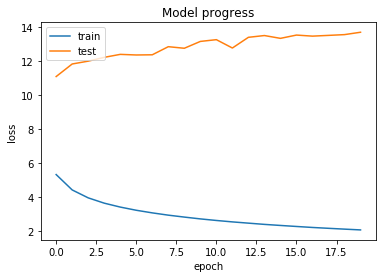

In [115]:
plt.figure(1)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Se entrena casi el cuadruple de parámetros, mientras que igualmente entrena de forma sólo ligeramente mas rápida que la red recurrente. Sin embargo si está obteniendo mejores resultados que la recurrente.

In [116]:
def predict_words(y_indexs, data="target"):
    """ Predict until '-#end-' is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["<end>/<end>"]:
                    return return_val                
    return return_val
n_s = 100
idx = np.random.choice(np.arange(Y_test.shape[0]), size=n_s, replace=False)
Y_set_pred = model.predict_classes(X_test[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p].split("/")[0] for p in predict_words(X_test[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p].split("/")[0] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p].split("/")[0] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled))

Texto source:  I like you just the way you are <end>
Texto target real:  Вы мне нравитесь таким какой Вы есть <end>
Texto target predicho:  Я <end>
Texto source:  I would like to visit you <end>
Texto target real:  Я бы хотела навестить тебя <end>
Texto target predicho:  Я <end>
Texto source:  We played baseball yesterday <end>
Texto target real:  Вчера мы играли в бейсбол <end>
Texto target predicho:  Я <end>
Texto source:  I 've painted the ceiling <end>
Texto target real:  Я покрасил потолок <end>
Texto target predicho:  Я <end>
Texto source:  I want to hit the road <end>
Texto target real:  Я хочу <end>
Texto target predicho:  Я <end>
Texto source:  You need to decide <end>
Texto target real:  Тебе нужно решать <end>
Texto target predicho:  Я <end>
Texto source:  It was n't difficult <end>
Texto target real:  Это было несложно <end>
Texto target predicho:  Я <end>
Texto source:  Am I a prisoner <end>
Texto target real:  Я заключённый <end>
Texto target predicho:  Я <end>
Texto sour

In [117]:
n_s = 100
idx = np.random.choice(np.arange(Y_test.shape[0]), size=n_s, replace=False)
Y_set_pred = modelCnn.predict_classes(X_test[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p].split("/")[0] for p in predict_words(X_test[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p].split("/")[0] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p].split("/")[0] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled))

Texto source:  Do you think television does children harm <end>
Texto target real:  ли вы что приносит вред детям <end>
Texto target predicho:  Ты не на на <end>
Texto source:  You are n't here <end>
Texto target real:  Тебя здесь нет <end>
Texto target predicho:  Ты здесь нет <end>
Texto source:  I love my sisters <end>
Texto target real:  Я люблю моих <end>
Texto target predicho:  Я люблю люблю <end>
Texto source:  I want you to sit here <end>
Texto target real:  Я хочу чтобы ты здесь <end>
Texto target predicho:  Я хочу чтобы ты здесь <end>
Texto source:  We 're thieves <end>
Texto target real:  Мы <end>
Texto target predicho:  Мы <end>
Texto source:  I just wanted to give you a heads up <end>
Texto target real:  Я просто хотел предупредить вас <end>
Texto target predicho:  Я просто хотел вам тебе <end>
Texto source:  I 'd be willing to help <end>
Texto target real:  Я бы помочь <end>
Texto target predicho:  Я бы бы помочь помочь <end>
Texto source:  He does n't look happy to see me

El desempeño del modelo convolucional es notoriamente mejor que el recurrente, ya que el último solamente puede decir Yo en ruso. Además, el modelo convolucional además predice la gran mayoría sino correctamente al menos cercano a lo que debería ser, aunque si falla con las palabras que no están agregadas al vocabulario, que en su mayoría son nombres.

Para el cambio significativo que le aplicaremos a la red, lo que haremos será ocupar un Embedding pre entrenado, en este caso [GloVe](https://nlp.stanford.edu/projects/glove/)

In [120]:
embeddings_index = {}
import os
with open(os.path.join('./glove', 'glove.6B.100d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [126]:
EMBEDDING_DIM = 100
# prepare embedding matrix
num_words = n_words_s
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_s.items():
    if i >= n_words_s:
        continue
    embedding_vector = embeddings_index.get(word.split("/")[0])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [128]:
from keras.initializers import Constant
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_inp_length,
                            trainable=False)

In [131]:
modelOwn = Sequential()
modelOwn.add(embedding_layer)
modelOwn.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modelOwn.add(BatchNormalization()) #for stability
modelOwn.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modelOwn.add(BatchNormalization())
modelOwn.add(GlobalMaxPooling1D())

modelOwn.add(RepeatVector(max_out_length))

modelOwn.add(CuDNNGRU(128, return_sequences=True))
modelOwn.add(CuDNNGRU(64, return_sequences=True))
modelOwn.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
modelOwn.summary()
modelOwn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 44, 100)           548200    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 44, 256)           128256    
_________________________________________________________________
batch_normalization_9 (Batch (None, 44, 256)           1024      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 44, 256)           327936    
_________________________________________________________________
batch_normalization_10 (Batc (None, 44, 256)           1024      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 40, 256)           0         
__________

In [132]:
hist3 = modelOwn.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_valid, Y_valid),
         sample_weight = sample_weight)

Train on 169534 samples, validate on 10000 samples
Epoch 1/20


 79616/169534 [=============>................] - ETA: 24:39 - loss: 9.28 - ETA: 13:18 - loss: 9.25 - ETA: 9:29 - loss: 9.2356 - ETA: 7:33 - loss: 9.212 - ETA: 6:24 - loss: 9.189 - ETA: 5:38 - loss: 9.164 - ETA: 5:05 - loss: 9.137 - ETA: 4:40 - loss: 9.110 - ETA: 4:21 - loss: 9.081 - ETA: 4:05 - loss: 9.050 - ETA: 3:53 - loss: 9.017 - ETA: 3:42 - loss: 8.985 - ETA: 3:33 - loss: 8.952 - ETA: 3:25 - loss: 8.918 - ETA: 3:18 - loss: 8.883 - ETA: 3:12 - loss: 8.846 - ETA: 3:07 - loss: 8.809 - ETA: 3:02 - loss: 8.773 - ETA: 2:58 - loss: 8.738 - ETA: 2:54 - loss: 8.702 - ETA: 2:51 - loss: 8.664 - ETA: 2:47 - loss: 8.628 - ETA: 2:44 - loss: 8.594 - ETA: 2:42 - loss: 8.557 - ETA: 2:39 - loss: 8.521 - ETA: 2:37 - loss: 8.486 - ETA: 2:35 - loss: 8.451 - ETA: 2:33 - loss: 8.418 - ETA: 2:31 - loss: 8.384 - ETA: 2:29 - loss: 8.351 - ETA: 2:27 - loss: 8.320 - ETA: 2:26 - loss: 8.288 - ETA: 2:24 - loss: 8.258 - ETA: 2:23 - loss: 8.226 - ETA: 2:22 - loss: 8.196 - ETA: 2:20 - loss: 8.166 - ETA: 2:19 - lo

169534/169534 [==============================] - ETA: 1s - loss: 6.241 - ETA: 1s - loss: 6.241 - ETA: 1s - loss: 6.240 - ETA: 1s - loss: 6.240 - ETA: 1s - loss: 6.240 - ETA: 1s - loss: 6.239 - ETA: 0s - loss: 6.239 - ETA: 0s - loss: 6.239 - ETA: 0s - loss: 6.238 - ETA: 0s - loss: 6.238 - ETA: 0s - loss: 6.238 - ETA: 0s - loss: 6.237 - 118s 696us/step - loss: 6.2377 - val_loss: 13.4093
Epoch 2/20


 80384/169534 [=============>................] - ETA: 1:53 - loss: 6.031 - ETA: 1:51 - loss: 6.017 - ETA: 1:49 - loss: 5.999 - ETA: 1:49 - loss: 6.012 - ETA: 1:51 - loss: 5.990 - ETA: 1:50 - loss: 5.985 - ETA: 1:50 - loss: 5.997 - ETA: 1:50 - loss: 6.001 - ETA: 1:50 - loss: 5.994 - ETA: 1:50 - loss: 5.986 - ETA: 1:50 - loss: 5.982 - ETA: 1:50 - loss: 5.977 - ETA: 1:50 - loss: 5.974 - ETA: 1:50 - loss: 5.973 - ETA: 1:51 - loss: 5.967 - ETA: 1:52 - loss: 5.969 - ETA: 1:52 - loss: 5.968 - ETA: 1:51 - loss: 5.973 - ETA: 1:51 - loss: 5.975 - ETA: 1:52 - loss: 5.972 - ETA: 1:51 - loss: 5.970 - ETA: 1:51 - loss: 5.973 - ETA: 1:51 - loss: 5.968 - ETA: 1:51 - loss: 5.967 - ETA: 1:51 - loss: 5.964 - ETA: 1:51 - loss: 5.966 - ETA: 1:51 - loss: 5.963 - ETA: 1:52 - loss: 5.960 - ETA: 1:52 - loss: 5.960 - ETA: 1:52 - loss: 5.957 - ETA: 1:52 - loss: 5.956 - ETA: 1:51 - loss: 5.956 - ETA: 1:51 - loss: 5.958 - ETA: 1:51 - loss: 5.957 - ETA: 1:50 - loss: 5.954 - ETA: 1:50 - loss: 5.955 - ETA: 1:50 - los

169534/169534 [==============================] - ETA: 1s - loss: 5.494 - ETA: 1s - loss: 5.493 - ETA: 0s - loss: 5.493 - ETA: 0s - loss: 5.492 - ETA: 0s - loss: 5.492 - ETA: 0s - loss: 5.491 - ETA: 0s - loss: 5.491 - ETA: 0s - loss: 5.490 - 118s 694us/step - loss: 5.4905 - val_loss: 14.0469
Epoch 3/20


 80384/169534 [=============>................] - ETA: 1:59 - loss: 5.120 - ETA: 1:55 - loss: 5.127 - ETA: 1:53 - loss: 5.139 - ETA: 1:53 - loss: 5.141 - ETA: 1:52 - loss: 5.148 - ETA: 1:52 - loss: 5.160 - ETA: 1:52 - loss: 5.155 - ETA: 1:51 - loss: 5.166 - ETA: 1:51 - loss: 5.166 - ETA: 1:51 - loss: 5.165 - ETA: 1:51 - loss: 5.162 - ETA: 1:51 - loss: 5.159 - ETA: 1:50 - loss: 5.161 - ETA: 1:50 - loss: 5.166 - ETA: 1:50 - loss: 5.162 - ETA: 1:50 - loss: 5.160 - ETA: 1:49 - loss: 5.157 - ETA: 1:49 - loss: 5.151 - ETA: 1:49 - loss: 5.150 - ETA: 1:49 - loss: 5.148 - ETA: 1:49 - loss: 5.144 - ETA: 1:49 - loss: 5.141 - ETA: 1:48 - loss: 5.142 - ETA: 1:48 - loss: 5.146 - ETA: 1:48 - loss: 5.143 - ETA: 1:48 - loss: 5.144 - ETA: 1:48 - loss: 5.145 - ETA: 1:48 - loss: 5.146 - ETA: 1:47 - loss: 5.145 - ETA: 1:47 - loss: 5.144 - ETA: 1:47 - loss: 5.146 - ETA: 1:47 - loss: 5.145 - ETA: 1:47 - loss: 5.142 - ETA: 1:47 - loss: 5.141 - ETA: 1:46 - loss: 5.141 - ETA: 1:46 - loss: 5.136 - ETA: 1:46 - los

169534/169534 [==============================] - ETA: 1s - loss: 4.948 - ETA: 1s - loss: 4.947 - ETA: 1s - loss: 4.947 - ETA: 0s - loss: 4.947 - ETA: 0s - loss: 4.947 - ETA: 0s - loss: 4.946 - ETA: 0s - loss: 4.946 - ETA: 0s - loss: 4.946 - ETA: 0s - loss: 4.946 - 119s 699us/step - loss: 4.9460 - val_loss: 14.4117
Epoch 4/20


 80384/169534 [=============>................] - ETA: 2:00 - loss: 4.800 - ETA: 1:58 - loss: 4.803 - ETA: 1:58 - loss: 4.801 - ETA: 1:56 - loss: 4.809 - ETA: 1:55 - loss: 4.791 - ETA: 1:55 - loss: 4.778 - ETA: 1:54 - loss: 4.787 - ETA: 1:54 - loss: 4.788 - ETA: 1:54 - loss: 4.770 - ETA: 1:55 - loss: 4.762 - ETA: 1:54 - loss: 4.750 - ETA: 1:54 - loss: 4.741 - ETA: 1:53 - loss: 4.742 - ETA: 1:53 - loss: 4.735 - ETA: 1:53 - loss: 4.735 - ETA: 1:53 - loss: 4.743 - ETA: 1:53 - loss: 4.750 - ETA: 1:52 - loss: 4.746 - ETA: 1:52 - loss: 4.742 - ETA: 1:52 - loss: 4.741 - ETA: 1:52 - loss: 4.734 - ETA: 1:52 - loss: 4.731 - ETA: 1:52 - loss: 4.729 - ETA: 1:51 - loss: 4.727 - ETA: 1:52 - loss: 4.720 - ETA: 1:52 - loss: 4.716 - ETA: 1:52 - loss: 4.717 - ETA: 1:52 - loss: 4.719 - ETA: 1:52 - loss: 4.715 - ETA: 1:53 - loss: 4.712 - ETA: 1:52 - loss: 4.713 - ETA: 1:52 - loss: 4.713 - ETA: 1:52 - loss: 4.711 - ETA: 1:51 - loss: 4.710 - ETA: 1:51 - loss: 4.712 - ETA: 1:51 - loss: 4.714 - ETA: 1:51 - los

169534/169534 [==============================] - ETA: 1s - loss: 4.613 - ETA: 1s - loss: 4.613 - ETA: 1s - loss: 4.613 - ETA: 0s - loss: 4.613 - ETA: 0s - loss: 4.612 - ETA: 0s - loss: 4.612 - ETA: 0s - loss: 4.612 - ETA: 0s - loss: 4.612 - ETA: 0s - loss: 4.612 - 118s 697us/step - loss: 4.6122 - val_loss: 14.4108
Epoch 5/20


 80384/169534 [=============>................] - ETA: 1:53 - loss: 4.538 - ETA: 1:53 - loss: 4.541 - ETA: 1:52 - loss: 4.534 - ETA: 1:52 - loss: 4.501 - ETA: 1:52 - loss: 4.493 - ETA: 1:51 - loss: 4.489 - ETA: 1:51 - loss: 4.491 - ETA: 1:52 - loss: 4.480 - ETA: 1:51 - loss: 4.458 - ETA: 1:51 - loss: 4.460 - ETA: 1:50 - loss: 4.469 - ETA: 1:50 - loss: 4.483 - ETA: 1:49 - loss: 4.486 - ETA: 1:49 - loss: 4.480 - ETA: 1:48 - loss: 4.486 - ETA: 1:48 - loss: 4.488 - ETA: 1:48 - loss: 4.484 - ETA: 1:47 - loss: 4.475 - ETA: 1:47 - loss: 4.465 - ETA: 1:47 - loss: 4.463 - ETA: 1:48 - loss: 4.459 - ETA: 1:48 - loss: 4.460 - ETA: 1:48 - loss: 4.458 - ETA: 1:48 - loss: 4.461 - ETA: 1:47 - loss: 4.466 - ETA: 1:47 - loss: 4.466 - ETA: 1:47 - loss: 4.467 - ETA: 1:47 - loss: 4.462 - ETA: 1:47 - loss: 4.463 - ETA: 1:47 - loss: 4.467 - ETA: 1:47 - loss: 4.465 - ETA: 1:47 - loss: 4.462 - ETA: 1:47 - loss: 4.462 - ETA: 1:47 - loss: 4.457 - ETA: 1:47 - loss: 4.456 - ETA: 1:47 - loss: 4.458 - ETA: 1:47 - los

169534/169534 [==============================] - ETA: 1s - loss: 4.359 - ETA: 1s - loss: 4.359 - ETA: 1s - loss: 4.359 - ETA: 0s - loss: 4.358 - ETA: 0s - loss: 4.358 - ETA: 0s - loss: 4.358 - ETA: 0s - loss: 4.358 - ETA: 0s - loss: 4.358 - ETA: 0s - loss: 4.358 - 120s 705us/step - loss: 4.3582 - val_loss: 14.3662
Epoch 6/20


 80640/169534 [=============>................] - ETA: 1:47 - loss: 4.310 - ETA: 1:47 - loss: 4.303 - ETA: 1:47 - loss: 4.331 - ETA: 1:47 - loss: 4.292 - ETA: 1:47 - loss: 4.245 - ETA: 1:47 - loss: 4.227 - ETA: 1:47 - loss: 4.231 - ETA: 1:47 - loss: 4.227 - ETA: 1:46 - loss: 4.237 - ETA: 1:46 - loss: 4.242 - ETA: 1:46 - loss: 4.245 - ETA: 1:46 - loss: 4.250 - ETA: 1:46 - loss: 4.250 - ETA: 1:45 - loss: 4.248 - ETA: 1:45 - loss: 4.243 - ETA: 1:45 - loss: 4.248 - ETA: 1:45 - loss: 4.237 - ETA: 1:45 - loss: 4.231 - ETA: 1:45 - loss: 4.227 - ETA: 1:45 - loss: 4.229 - ETA: 1:44 - loss: 4.233 - ETA: 1:44 - loss: 4.238 - ETA: 1:45 - loss: 4.241 - ETA: 1:45 - loss: 4.239 - ETA: 1:44 - loss: 4.237 - ETA: 1:45 - loss: 4.242 - ETA: 1:45 - loss: 4.239 - ETA: 1:44 - loss: 4.244 - ETA: 1:44 - loss: 4.239 - ETA: 1:44 - loss: 4.235 - ETA: 1:44 - loss: 4.236 - ETA: 1:44 - loss: 4.237 - ETA: 1:44 - loss: 4.234 - ETA: 1:43 - loss: 4.232 - ETA: 1:43 - loss: 4.228 - ETA: 1:43 - loss: 4.227 - ETA: 1:43 - los

169534/169534 [==============================] - ETA: 1s - loss: 4.143 - ETA: 0s - loss: 4.143 - ETA: 0s - loss: 4.143 - ETA: 0s - loss: 4.143 - ETA: 0s - loss: 4.143 - ETA: 0s - loss: 4.143 - ETA: 0s - loss: 4.142 - 112s 660us/step - loss: 4.1427 - val_loss: 14.3489
Epoch 7/20


 80640/169534 [=============>................] - ETA: 1:53 - loss: 4.068 - ETA: 1:50 - loss: 4.013 - ETA: 1:49 - loss: 4.013 - ETA: 1:48 - loss: 4.023 - ETA: 1:48 - loss: 4.031 - ETA: 1:48 - loss: 4.035 - ETA: 1:47 - loss: 4.038 - ETA: 1:47 - loss: 4.066 - ETA: 1:47 - loss: 4.058 - ETA: 1:46 - loss: 4.046 - ETA: 1:46 - loss: 4.034 - ETA: 1:46 - loss: 4.038 - ETA: 1:46 - loss: 4.034 - ETA: 1:46 - loss: 4.025 - ETA: 1:46 - loss: 4.019 - ETA: 1:45 - loss: 4.026 - ETA: 1:45 - loss: 4.027 - ETA: 1:45 - loss: 4.036 - ETA: 1:45 - loss: 4.036 - ETA: 1:45 - loss: 4.036 - ETA: 1:44 - loss: 4.035 - ETA: 1:44 - loss: 4.031 - ETA: 1:44 - loss: 4.026 - ETA: 1:44 - loss: 4.025 - ETA: 1:44 - loss: 4.024 - ETA: 1:44 - loss: 4.025 - ETA: 1:43 - loss: 4.026 - ETA: 1:43 - loss: 4.024 - ETA: 1:43 - loss: 4.018 - ETA: 1:43 - loss: 4.016 - ETA: 1:43 - loss: 4.013 - ETA: 1:43 - loss: 4.015 - ETA: 1:42 - loss: 4.016 - ETA: 1:42 - loss: 4.017 - ETA: 1:42 - loss: 4.019 - ETA: 1:43 - loss: 4.020 - ETA: 1:42 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.963 - ETA: 0s - loss: 3.963 - ETA: 0s - loss: 3.963 - ETA: 0s - loss: 3.963 - ETA: 0s - loss: 3.963 - ETA: 0s - loss: 3.963 - ETA: 0s - loss: 3.962 - 110s 649us/step - loss: 3.9629 - val_loss: 14.3239
Epoch 8/20


 80896/169534 [=============>................] - ETA: 1:46 - loss: 3.984 - ETA: 1:46 - loss: 3.940 - ETA: 1:46 - loss: 3.942 - ETA: 1:46 - loss: 3.905 - ETA: 1:46 - loss: 3.911 - ETA: 1:45 - loss: 3.871 - ETA: 1:45 - loss: 3.874 - ETA: 1:45 - loss: 3.897 - ETA: 1:45 - loss: 3.876 - ETA: 1:45 - loss: 3.871 - ETA: 1:45 - loss: 3.862 - ETA: 1:45 - loss: 3.857 - ETA: 1:45 - loss: 3.853 - ETA: 1:45 - loss: 3.861 - ETA: 1:44 - loss: 3.865 - ETA: 1:44 - loss: 3.855 - ETA: 1:44 - loss: 3.847 - ETA: 1:44 - loss: 3.843 - ETA: 1:44 - loss: 3.842 - ETA: 1:44 - loss: 3.836 - ETA: 1:44 - loss: 3.834 - ETA: 1:43 - loss: 3.834 - ETA: 1:43 - loss: 3.835 - ETA: 1:43 - loss: 3.839 - ETA: 1:43 - loss: 3.839 - ETA: 1:43 - loss: 3.839 - ETA: 1:43 - loss: 3.844 - ETA: 1:42 - loss: 3.844 - ETA: 1:42 - loss: 3.848 - ETA: 1:42 - loss: 3.844 - ETA: 1:42 - loss: 3.845 - ETA: 1:42 - loss: 3.844 - ETA: 1:42 - loss: 3.842 - ETA: 1:41 - loss: 3.843 - ETA: 1:41 - loss: 3.841 - ETA: 1:41 - loss: 3.843 - ETA: 1:41 - los

169534/169534 [==============================] - ETA: 0s - loss: 3.809 - ETA: 0s - loss: 3.808 - ETA: 0s - loss: 3.808 - ETA: 0s - loss: 3.808 - ETA: 0s - loss: 3.809 - ETA: 0s - loss: 3.809 - 109s 644us/step - loss: 3.8094 - val_loss: 14.3089
Epoch 9/20


 80896/169534 [=============>................] - ETA: 1:47 - loss: 3.776 - ETA: 1:45 - loss: 3.693 - ETA: 1:46 - loss: 3.701 - ETA: 1:46 - loss: 3.698 - ETA: 1:46 - loss: 3.713 - ETA: 1:45 - loss: 3.695 - ETA: 1:45 - loss: 3.705 - ETA: 1:45 - loss: 3.699 - ETA: 1:45 - loss: 3.709 - ETA: 1:45 - loss: 3.704 - ETA: 1:45 - loss: 3.701 - ETA: 1:44 - loss: 3.702 - ETA: 1:44 - loss: 3.714 - ETA: 1:44 - loss: 3.706 - ETA: 1:44 - loss: 3.696 - ETA: 1:44 - loss: 3.707 - ETA: 1:44 - loss: 3.696 - ETA: 1:43 - loss: 3.692 - ETA: 1:43 - loss: 3.695 - ETA: 1:43 - loss: 3.694 - ETA: 1:43 - loss: 3.692 - ETA: 1:43 - loss: 3.701 - ETA: 1:43 - loss: 3.708 - ETA: 1:42 - loss: 3.703 - ETA: 1:42 - loss: 3.706 - ETA: 1:42 - loss: 3.707 - ETA: 1:42 - loss: 3.705 - ETA: 1:42 - loss: 3.708 - ETA: 1:42 - loss: 3.708 - ETA: 1:41 - loss: 3.706 - ETA: 1:41 - loss: 3.702 - ETA: 1:41 - loss: 3.700 - ETA: 1:41 - loss: 3.699 - ETA: 1:41 - loss: 3.697 - ETA: 1:41 - loss: 3.696 - ETA: 1:41 - loss: 3.696 - ETA: 1:40 - los

169534/169534 [==============================] - ETA: 0s - loss: 3.674 - ETA: 0s - loss: 3.674 - ETA: 0s - loss: 3.674 - ETA: 0s - loss: 3.673 - ETA: 0s - loss: 3.673 - ETA: 0s - loss: 3.673 - 110s 646us/step - loss: 3.6735 - val_loss: 14.2906
Epoch 10/20


 80384/169534 [=============>................] - ETA: 1:47 - loss: 3.783 - ETA: 1:46 - loss: 3.704 - ETA: 1:46 - loss: 3.677 - ETA: 1:46 - loss: 3.686 - ETA: 1:46 - loss: 3.676 - ETA: 1:46 - loss: 3.666 - ETA: 1:46 - loss: 3.631 - ETA: 1:45 - loss: 3.626 - ETA: 1:45 - loss: 3.629 - ETA: 1:45 - loss: 3.627 - ETA: 1:45 - loss: 3.617 - ETA: 1:45 - loss: 3.623 - ETA: 1:44 - loss: 3.616 - ETA: 1:44 - loss: 3.615 - ETA: 1:44 - loss: 3.601 - ETA: 1:44 - loss: 3.597 - ETA: 1:44 - loss: 3.601 - ETA: 1:44 - loss: 3.595 - ETA: 1:43 - loss: 3.599 - ETA: 1:43 - loss: 3.599 - ETA: 1:43 - loss: 3.598 - ETA: 1:43 - loss: 3.594 - ETA: 1:43 - loss: 3.588 - ETA: 1:43 - loss: 3.584 - ETA: 1:42 - loss: 3.583 - ETA: 1:42 - loss: 3.582 - ETA: 1:42 - loss: 3.585 - ETA: 1:42 - loss: 3.586 - ETA: 1:42 - loss: 3.588 - ETA: 1:42 - loss: 3.587 - ETA: 1:41 - loss: 3.581 - ETA: 1:41 - loss: 3.580 - ETA: 1:41 - loss: 3.575 - ETA: 1:41 - loss: 3.573 - ETA: 1:41 - loss: 3.574 - ETA: 1:41 - loss: 3.572 - ETA: 1:41 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.553 - ETA: 1s - loss: 3.552 - ETA: 0s - loss: 3.552 - ETA: 0s - loss: 3.552 - ETA: 0s - loss: 3.552 - ETA: 0s - loss: 3.552 - ETA: 0s - loss: 3.552 - ETA: 0s - loss: 3.552 - 114s 671us/step - loss: 3.5522 - val_loss: 14.2760
Epoch 11/20


 80384/169534 [=============>................] - ETA: 1:53 - loss: 3.330 - ETA: 1:50 - loss: 3.272 - ETA: 1:49 - loss: 3.342 - ETA: 1:49 - loss: 3.376 - ETA: 1:49 - loss: 3.407 - ETA: 1:48 - loss: 3.405 - ETA: 1:48 - loss: 3.401 - ETA: 1:50 - loss: 3.393 - ETA: 1:49 - loss: 3.403 - ETA: 1:49 - loss: 3.414 - ETA: 1:48 - loss: 3.415 - ETA: 1:48 - loss: 3.410 - ETA: 1:48 - loss: 3.420 - ETA: 1:49 - loss: 3.423 - ETA: 1:49 - loss: 3.432 - ETA: 1:48 - loss: 3.432 - ETA: 1:48 - loss: 3.438 - ETA: 1:48 - loss: 3.429 - ETA: 1:48 - loss: 3.427 - ETA: 1:48 - loss: 3.425 - ETA: 1:47 - loss: 3.429 - ETA: 1:47 - loss: 3.428 - ETA: 1:47 - loss: 3.430 - ETA: 1:46 - loss: 3.433 - ETA: 1:46 - loss: 3.433 - ETA: 1:46 - loss: 3.436 - ETA: 1:46 - loss: 3.432 - ETA: 1:46 - loss: 3.435 - ETA: 1:46 - loss: 3.435 - ETA: 1:46 - loss: 3.434 - ETA: 1:45 - loss: 3.433 - ETA: 1:46 - loss: 3.435 - ETA: 1:46 - loss: 3.436 - ETA: 1:46 - loss: 3.432 - ETA: 1:45 - loss: 3.431 - ETA: 1:45 - loss: 3.430 - ETA: 1:45 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.447 - ETA: 1s - loss: 3.447 - ETA: 0s - loss: 3.447 - ETA: 0s - loss: 3.447 - ETA: 0s - loss: 3.447 - ETA: 0s - loss: 3.446 - ETA: 0s - loss: 3.446 - ETA: 0s - loss: 3.446 - 115s 679us/step - loss: 3.4468 - val_loss: 14.2805
Epoch 12/20


 80384/169534 [=============>................] - ETA: 1:47 - loss: 3.375 - ETA: 1:47 - loss: 3.359 - ETA: 1:47 - loss: 3.400 - ETA: 1:46 - loss: 3.387 - ETA: 1:46 - loss: 3.370 - ETA: 1:46 - loss: 3.391 - ETA: 1:46 - loss: 3.399 - ETA: 1:46 - loss: 3.403 - ETA: 1:46 - loss: 3.401 - ETA: 1:45 - loss: 3.408 - ETA: 1:45 - loss: 3.392 - ETA: 1:45 - loss: 3.395 - ETA: 1:45 - loss: 3.385 - ETA: 1:45 - loss: 3.381 - ETA: 1:45 - loss: 3.373 - ETA: 1:45 - loss: 3.369 - ETA: 1:45 - loss: 3.372 - ETA: 1:44 - loss: 3.366 - ETA: 1:44 - loss: 3.370 - ETA: 1:44 - loss: 3.380 - ETA: 1:44 - loss: 3.383 - ETA: 1:44 - loss: 3.378 - ETA: 1:43 - loss: 3.373 - ETA: 1:43 - loss: 3.373 - ETA: 1:43 - loss: 3.374 - ETA: 1:43 - loss: 3.376 - ETA: 1:43 - loss: 3.375 - ETA: 1:43 - loss: 3.378 - ETA: 1:44 - loss: 3.375 - ETA: 1:44 - loss: 3.376 - ETA: 1:45 - loss: 3.372 - ETA: 1:44 - loss: 3.368 - ETA: 1:44 - loss: 3.367 - ETA: 1:45 - loss: 3.366 - ETA: 1:45 - loss: 3.369 - ETA: 1:45 - loss: 3.368 - ETA: 1:45 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.346 - ETA: 1s - loss: 3.346 - ETA: 1s - loss: 3.346 - ETA: 1s - loss: 3.346 - ETA: 1s - loss: 3.346 - ETA: 0s - loss: 3.346 - ETA: 0s - loss: 3.345 - ETA: 0s - loss: 3.346 - ETA: 0s - loss: 3.346 - ETA: 0s - loss: 3.346 - 135s 799us/step - loss: 3.3464 - val_loss: 14.2677
Epoch 13/20


 80384/169534 [=============>................] - ETA: 2:04 - loss: 3.190 - ETA: 1:58 - loss: 3.234 - ETA: 1:57 - loss: 3.228 - ETA: 1:55 - loss: 3.251 - ETA: 1:54 - loss: 3.250 - ETA: 1:54 - loss: 3.214 - ETA: 1:54 - loss: 3.225 - ETA: 1:53 - loss: 3.237 - ETA: 1:53 - loss: 3.262 - ETA: 1:52 - loss: 3.273 - ETA: 1:52 - loss: 3.273 - ETA: 1:52 - loss: 3.256 - ETA: 1:51 - loss: 3.259 - ETA: 1:51 - loss: 3.246 - ETA: 1:51 - loss: 3.247 - ETA: 1:51 - loss: 3.247 - ETA: 1:50 - loss: 3.243 - ETA: 1:50 - loss: 3.252 - ETA: 1:50 - loss: 3.255 - ETA: 1:50 - loss: 3.258 - ETA: 1:50 - loss: 3.263 - ETA: 1:49 - loss: 3.259 - ETA: 1:49 - loss: 3.272 - ETA: 1:49 - loss: 3.272 - ETA: 1:49 - loss: 3.271 - ETA: 1:49 - loss: 3.270 - ETA: 1:49 - loss: 3.272 - ETA: 1:49 - loss: 3.271 - ETA: 1:48 - loss: 3.273 - ETA: 1:48 - loss: 3.275 - ETA: 1:48 - loss: 3.273 - ETA: 1:48 - loss: 3.275 - ETA: 1:48 - loss: 3.271 - ETA: 1:47 - loss: 3.268 - ETA: 1:47 - loss: 3.267 - ETA: 1:47 - loss: 3.272 - ETA: 1:47 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.267 - ETA: 1s - loss: 3.267 - ETA: 1s - loss: 3.267 - ETA: 1s - loss: 3.267 - ETA: 1s - loss: 3.267 - ETA: 0s - loss: 3.267 - ETA: 0s - loss: 3.267 - ETA: 0s - loss: 3.267 - ETA: 0s - loss: 3.267 - ETA: 0s - loss: 3.267 - ETA: 0s - loss: 3.267 - 126s 743us/step - loss: 3.2674 - val_loss: 14.2500
Epoch 14/20


 80384/169534 [=============>................] - ETA: 2:12 - loss: 3.191 - ETA: 2:06 - loss: 3.236 - ETA: 2:05 - loss: 3.183 - ETA: 2:04 - loss: 3.191 - ETA: 2:04 - loss: 3.174 - ETA: 2:03 - loss: 3.174 - ETA: 2:02 - loss: 3.165 - ETA: 2:01 - loss: 3.175 - ETA: 2:01 - loss: 3.179 - ETA: 2:01 - loss: 3.182 - ETA: 2:00 - loss: 3.179 - ETA: 2:00 - loss: 3.181 - ETA: 1:59 - loss: 3.182 - ETA: 1:59 - loss: 3.189 - ETA: 1:58 - loss: 3.196 - ETA: 1:58 - loss: 3.188 - ETA: 1:58 - loss: 3.188 - ETA: 1:58 - loss: 3.187 - ETA: 1:58 - loss: 3.188 - ETA: 1:58 - loss: 3.191 - ETA: 1:57 - loss: 3.190 - ETA: 1:57 - loss: 3.194 - ETA: 1:57 - loss: 3.190 - ETA: 1:57 - loss: 3.185 - ETA: 1:56 - loss: 3.187 - ETA: 1:56 - loss: 3.186 - ETA: 1:56 - loss: 3.192 - ETA: 1:56 - loss: 3.191 - ETA: 1:55 - loss: 3.189 - ETA: 1:55 - loss: 3.186 - ETA: 1:55 - loss: 3.179 - ETA: 1:55 - loss: 3.178 - ETA: 1:55 - loss: 3.175 - ETA: 1:55 - loss: 3.175 - ETA: 1:55 - loss: 3.172 - ETA: 1:55 - loss: 3.169 - ETA: 1:55 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.186 - ETA: 1s - loss: 3.186 - ETA: 1s - loss: 3.186 - ETA: 1s - loss: 3.186 - ETA: 0s - loss: 3.186 - ETA: 0s - loss: 3.186 - ETA: 0s - loss: 3.186 - ETA: 0s - loss: 3.186 - ETA: 0s - loss: 3.186 - ETA: 0s - loss: 3.186 - 124s 731us/step - loss: 3.1862 - val_loss: 14.2399
Epoch 15/20


 80384/169534 [=============>................] - ETA: 2:06 - loss: 3.081 - ETA: 2:07 - loss: 3.085 - ETA: 2:04 - loss: 3.056 - ETA: 2:03 - loss: 3.043 - ETA: 2:02 - loss: 3.028 - ETA: 2:02 - loss: 3.023 - ETA: 2:02 - loss: 3.027 - ETA: 2:01 - loss: 3.049 - ETA: 2:01 - loss: 3.049 - ETA: 2:00 - loss: 3.063 - ETA: 2:00 - loss: 3.067 - ETA: 2:00 - loss: 3.073 - ETA: 1:59 - loss: 3.078 - ETA: 2:00 - loss: 3.097 - ETA: 2:00 - loss: 3.111 - ETA: 1:59 - loss: 3.098 - ETA: 1:59 - loss: 3.093 - ETA: 1:59 - loss: 3.095 - ETA: 1:59 - loss: 3.090 - ETA: 1:59 - loss: 3.084 - ETA: 1:59 - loss: 3.082 - ETA: 1:59 - loss: 3.081 - ETA: 1:59 - loss: 3.082 - ETA: 1:59 - loss: 3.082 - ETA: 1:59 - loss: 3.079 - ETA: 1:58 - loss: 3.079 - ETA: 1:58 - loss: 3.075 - ETA: 1:58 - loss: 3.077 - ETA: 1:58 - loss: 3.083 - ETA: 1:58 - loss: 3.087 - ETA: 1:57 - loss: 3.087 - ETA: 1:57 - loss: 3.085 - ETA: 1:57 - loss: 3.087 - ETA: 1:57 - loss: 3.089 - ETA: 1:56 - loss: 3.089 - ETA: 1:56 - loss: 3.087 - ETA: 1:56 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.114 - ETA: 1s - loss: 3.114 - ETA: 1s - loss: 3.114 - ETA: 1s - loss: 3.114 - ETA: 0s - loss: 3.113 - ETA: 0s - loss: 3.114 - ETA: 0s - loss: 3.114 - ETA: 0s - loss: 3.114 - ETA: 0s - loss: 3.114 - ETA: 0s - loss: 3.114 - 124s 734us/step - loss: 3.1142 - val_loss: 14.2315
Epoch 16/20


 80384/169534 [=============>................] - ETA: 2:03 - loss: 2.990 - ETA: 2:03 - loss: 2.986 - ETA: 2:03 - loss: 3.057 - ETA: 2:03 - loss: 3.047 - ETA: 2:03 - loss: 3.011 - ETA: 2:02 - loss: 2.985 - ETA: 2:02 - loss: 2.997 - ETA: 2:02 - loss: 3.015 - ETA: 2:02 - loss: 3.015 - ETA: 2:01 - loss: 3.032 - ETA: 2:01 - loss: 3.030 - ETA: 2:00 - loss: 3.023 - ETA: 2:00 - loss: 3.013 - ETA: 2:00 - loss: 3.020 - ETA: 2:00 - loss: 3.017 - ETA: 1:59 - loss: 3.005 - ETA: 1:59 - loss: 3.011 - ETA: 1:59 - loss: 3.004 - ETA: 1:59 - loss: 3.002 - ETA: 1:59 - loss: 3.003 - ETA: 1:58 - loss: 3.000 - ETA: 1:58 - loss: 2.999 - ETA: 1:58 - loss: 3.003 - ETA: 1:58 - loss: 3.010 - ETA: 1:58 - loss: 3.015 - ETA: 1:57 - loss: 3.012 - ETA: 1:57 - loss: 3.012 - ETA: 1:57 - loss: 3.018 - ETA: 1:57 - loss: 3.017 - ETA: 1:57 - loss: 3.018 - ETA: 1:57 - loss: 3.015 - ETA: 1:56 - loss: 3.020 - ETA: 1:56 - loss: 3.018 - ETA: 1:56 - loss: 3.023 - ETA: 1:56 - loss: 3.020 - ETA: 1:56 - loss: 3.024 - ETA: 1:56 - los

169534/169534 [==============================] - ETA: 1s - loss: 3.049 - ETA: 1s - loss: 3.049 - ETA: 1s - loss: 3.049 - ETA: 1s - loss: 3.049 - ETA: 0s - loss: 3.049 - ETA: 0s - loss: 3.049 - ETA: 0s - loss: 3.049 - ETA: 0s - loss: 3.049 - ETA: 0s - loss: 3.049 - ETA: 0s - loss: 3.049 - 123s 728us/step - loss: 3.0498 - val_loss: 14.2307
Epoch 17/20


 80384/169534 [=============>................] - ETA: 1:56 - loss: 2.899 - ETA: 1:56 - loss: 2.862 - ETA: 1:56 - loss: 2.919 - ETA: 1:59 - loss: 2.929 - ETA: 1:59 - loss: 2.920 - ETA: 1:59 - loss: 2.908 - ETA: 1:59 - loss: 2.933 - ETA: 1:59 - loss: 2.911 - ETA: 1:59 - loss: 2.919 - ETA: 1:59 - loss: 2.916 - ETA: 1:59 - loss: 2.929 - ETA: 1:59 - loss: 2.918 - ETA: 1:59 - loss: 2.927 - ETA: 1:59 - loss: 2.920 - ETA: 1:59 - loss: 2.915 - ETA: 1:59 - loss: 2.924 - ETA: 1:59 - loss: 2.925 - ETA: 1:58 - loss: 2.919 - ETA: 1:58 - loss: 2.919 - ETA: 1:58 - loss: 2.924 - ETA: 1:58 - loss: 2.927 - ETA: 1:57 - loss: 2.928 - ETA: 1:57 - loss: 2.932 - ETA: 1:57 - loss: 2.934 - ETA: 1:57 - loss: 2.928 - ETA: 1:57 - loss: 2.929 - ETA: 1:57 - loss: 2.929 - ETA: 1:57 - loss: 2.929 - ETA: 1:57 - loss: 2.932 - ETA: 1:57 - loss: 2.933 - ETA: 1:56 - loss: 2.937 - ETA: 1:56 - loss: 2.943 - ETA: 1:56 - loss: 2.949 - ETA: 1:56 - loss: 2.958 - ETA: 1:56 - loss: 2.960 - ETA: 1:55 - loss: 2.961 - ETA: 1:55 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.991 - ETA: 1s - loss: 2.991 - ETA: 1s - loss: 2.991 - ETA: 1s - loss: 2.991 - ETA: 0s - loss: 2.991 - ETA: 0s - loss: 2.991 - ETA: 0s - loss: 2.991 - ETA: 0s - loss: 2.991 - ETA: 0s - loss: 2.991 - ETA: 0s - loss: 2.991 - 126s 742us/step - loss: 2.9913 - val_loss: 14.2380
Epoch 18/20


 80384/169534 [=============>................] - ETA: 2:02 - loss: 2.859 - ETA: 2:01 - loss: 2.838 - ETA: 2:02 - loss: 2.877 - ETA: 2:02 - loss: 2.904 - ETA: 2:02 - loss: 2.937 - ETA: 2:01 - loss: 2.943 - ETA: 2:01 - loss: 2.935 - ETA: 2:01 - loss: 2.923 - ETA: 2:00 - loss: 2.928 - ETA: 2:00 - loss: 2.934 - ETA: 2:00 - loss: 2.930 - ETA: 2:00 - loss: 2.937 - ETA: 2:00 - loss: 2.944 - ETA: 1:59 - loss: 2.944 - ETA: 2:00 - loss: 2.936 - ETA: 2:00 - loss: 2.923 - ETA: 2:00 - loss: 2.924 - ETA: 1:59 - loss: 2.915 - ETA: 1:59 - loss: 2.910 - ETA: 1:59 - loss: 2.910 - ETA: 1:59 - loss: 2.910 - ETA: 1:59 - loss: 2.912 - ETA: 1:59 - loss: 2.910 - ETA: 1:59 - loss: 2.913 - ETA: 1:59 - loss: 2.914 - ETA: 1:58 - loss: 2.916 - ETA: 1:58 - loss: 2.913 - ETA: 1:58 - loss: 2.915 - ETA: 1:58 - loss: 2.912 - ETA: 1:58 - loss: 2.912 - ETA: 1:58 - loss: 2.909 - ETA: 1:58 - loss: 2.911 - ETA: 1:58 - loss: 2.912 - ETA: 1:57 - loss: 2.913 - ETA: 1:57 - loss: 2.915 - ETA: 1:57 - loss: 2.918 - ETA: 1:57 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.933 - ETA: 1s - loss: 2.932 - ETA: 1s - loss: 2.932 - ETA: 1s - loss: 2.933 - ETA: 0s - loss: 2.933 - ETA: 0s - loss: 2.933 - ETA: 0s - loss: 2.933 - ETA: 0s - loss: 2.933 - ETA: 0s - loss: 2.933 - ETA: 0s - loss: 2.933 - 125s 740us/step - loss: 2.9335 - val_loss: 14.2209
Epoch 19/20


 80384/169534 [=============>................] - ETA: 2:09 - loss: 2.879 - ETA: 2:08 - loss: 2.864 - ETA: 2:07 - loss: 2.842 - ETA: 2:07 - loss: 2.807 - ETA: 2:07 - loss: 2.792 - ETA: 2:07 - loss: 2.800 - ETA: 2:07 - loss: 2.806 - ETA: 2:06 - loss: 2.826 - ETA: 2:06 - loss: 2.819 - ETA: 2:06 - loss: 2.821 - ETA: 2:05 - loss: 2.830 - ETA: 2:05 - loss: 2.832 - ETA: 2:05 - loss: 2.841 - ETA: 2:04 - loss: 2.842 - ETA: 2:04 - loss: 2.855 - ETA: 2:03 - loss: 2.868 - ETA: 2:03 - loss: 2.868 - ETA: 2:02 - loss: 2.859 - ETA: 2:02 - loss: 2.859 - ETA: 2:01 - loss: 2.865 - ETA: 2:01 - loss: 2.863 - ETA: 2:00 - loss: 2.863 - ETA: 2:00 - loss: 2.867 - ETA: 2:00 - loss: 2.858 - ETA: 1:59 - loss: 2.847 - ETA: 1:59 - loss: 2.847 - ETA: 1:59 - loss: 2.850 - ETA: 1:59 - loss: 2.846 - ETA: 1:58 - loss: 2.849 - ETA: 1:58 - loss: 2.849 - ETA: 1:58 - loss: 2.853 - ETA: 1:58 - loss: 2.855 - ETA: 1:58 - loss: 2.855 - ETA: 1:58 - loss: 2.851 - ETA: 1:57 - loss: 2.848 - ETA: 1:57 - loss: 2.847 - ETA: 1:57 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.878 - ETA: 1s - loss: 2.878 - ETA: 1s - loss: 2.878 - ETA: 1s - loss: 2.878 - ETA: 0s - loss: 2.878 - ETA: 0s - loss: 2.878 - ETA: 0s - loss: 2.878 - ETA: 0s - loss: 2.878 - ETA: 0s - loss: 2.878 - ETA: 0s - loss: 2.879 - 124s 730us/step - loss: 2.8791 - val_loss: 14.2209
Epoch 20/20


 80384/169534 [=============>................] - ETA: 2:02 - loss: 2.911 - ETA: 2:01 - loss: 2.816 - ETA: 2:00 - loss: 2.820 - ETA: 2:00 - loss: 2.814 - ETA: 2:00 - loss: 2.798 - ETA: 2:00 - loss: 2.772 - ETA: 1:59 - loss: 2.787 - ETA: 1:59 - loss: 2.801 - ETA: 1:59 - loss: 2.792 - ETA: 1:59 - loss: 2.790 - ETA: 1:59 - loss: 2.791 - ETA: 1:58 - loss: 2.795 - ETA: 1:58 - loss: 2.784 - ETA: 1:58 - loss: 2.784 - ETA: 1:58 - loss: 2.788 - ETA: 1:58 - loss: 2.788 - ETA: 1:58 - loss: 2.793 - ETA: 1:58 - loss: 2.786 - ETA: 1:58 - loss: 2.780 - ETA: 1:57 - loss: 2.773 - ETA: 1:57 - loss: 2.769 - ETA: 1:57 - loss: 2.784 - ETA: 1:57 - loss: 2.790 - ETA: 1:57 - loss: 2.796 - ETA: 1:57 - loss: 2.795 - ETA: 1:56 - loss: 2.796 - ETA: 1:56 - loss: 2.801 - ETA: 1:56 - loss: 2.801 - ETA: 1:56 - loss: 2.803 - ETA: 1:56 - loss: 2.802 - ETA: 1:56 - loss: 2.804 - ETA: 1:56 - loss: 2.799 - ETA: 1:55 - loss: 2.800 - ETA: 1:55 - loss: 2.803 - ETA: 1:55 - loss: 2.804 - ETA: 1:55 - loss: 2.804 - ETA: 1:54 - los

169534/169534 [==============================] - ETA: 1s - loss: 2.830 - ETA: 1s - loss: 2.830 - ETA: 1s - loss: 2.830 - ETA: 1s - loss: 2.830 - ETA: 0s - loss: 2.831 - ETA: 0s - loss: 2.831 - ETA: 0s - loss: 2.831 - ETA: 0s - loss: 2.831 - ETA: 0s - loss: 2.831 - ETA: 0s - loss: 2.831 - 125s 736us/step - loss: 2.8312 - val_loss: 14.2159


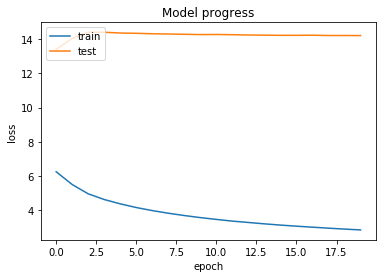

In [133]:
plt.figure(1)
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [134]:
n_s = 100
idx = np.random.choice(np.arange(Y_test.shape[0]), size=n_s, replace=False)
Y_set_pred = modelOwn.predict_classes(X_test[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p].split("/")[0] for p in predict_words(X_test[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p].split("/")[0] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p].split("/")[0] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled))

Texto source:  He wanted to teach English at school <end>
Texto target real:  Он хотел преподавать английский в школе <end>
Texto target predicho:  Том хотел играть в в школу <end>
Texto source:  I do n't usually dress like this <end>
Texto target real:  Обычно я так не <end>
Texto target predicho:  Я обычно не так так <end>
Texto source:  I think Tom is stubborn <end>
Texto target real:  Я думаю Том упрямый <end>
Texto target predicho:  Я думаю Том <end>
Texto source:  All of this is because of you <end>
Texto target real:  Всё это из за тебя <end>
Texto target predicho:  Что из из тебя тебя <end>
Texto source:  I 'm getting married on October 20th <end>
Texto target real:  Я женюсь октября <end>
Texto target predicho:  Я с в октября октября <end>
Texto source:  I do n't know whether you are telling the truth or not <end>
Texto target real:  Я не знаю говорите вы правду или нет <end>
Texto target predicho:  Я не знаю знаешь не или или или <end>
Texto source:  She lost her way and on t

En temas de calidad de predicción, el nuevo modelo no tiene un desempeño significativamente mejor que el anterior donde los embedding eran entrenables, aunque si era ligeramente mas rápido de entrenar y tenía una tasa de aprendizaje un tanto mas constante. Quizás con mas epoch hubiera tenido un mejor desempeño, hubiera convergido mejor que el otro modelo ya que el embed pre entrenado está hecho probado para que sea mejor que el que nosotros pudiésemos potencialmente entrenar.

Los items restantes no se realizaron por falta de tiempo, disculpe las molestias